We now create generalized linear models of the data (with elastic net regularization) using the venerable `glmnet` package.

For an introduction to `glmnet`, see https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html

We will be seeking to train a propensity model for CDI, which will allow us to create a matched cohort for parametric and non-parametric modeling of length of stay vs. CDI. Since CDI status is binary, this will be a logistic regression model. We'll create a model for five definitions of CDI based on EMR fields, since the literature varies on which one is best:

i. ICD-9 diagnosis code assigned for the visit

ii. Positive EIA C. diff toxin lab result during the visit

iii. Positive PCR C. diff toxin lab result during the visit

iv. Any positive toxin lab result during the visit

v. A visit meeting *any* of the above criteria

In [71]:
library(glmnet)
require(doMC)
registerDoMC(cores=11)
load(file="data/analysis_3.RData")
#load(file="data/analysis_3_glmnet.RData") # If you've already run fits and don't want to rerun.
#load(file="data/analysis_3_glmnet_perf.RData") # If you've already run performance bootstraps and don't want to rerun.

First, set up a helper function that translates dummy variable names w/ ICD9 codes or medication codes back into their human readable description.

In [4]:
med.df <- read.table('data/codelist_med_codes.tsv', sep="\t", quote="", header=TRUE, stringsAsFactors=FALSE)
dx.df <- read.table('data/codelist_seen_dxs.tsv', sep="\t", quote="", header=TRUE, stringsAsFactors=FALSE)

icd9_to_name <- dx.df$desc
names(icd9_to_name) <- dx.df$code

med_code_to_name <- med.df$name
names(med_code_to_name) <- med.df$code

de_code <- function(w_code) {
    code <- unlist(strsplit(w_code, ":"))
    ifelse(length(code) > 1 & grepl("^meds_", code[1]) & code[2] %in% names(med_code_to_name),
           med_code_to_name[code[2]],
           ifelse(length(code) > 1 & code[2] %in% names(icd9_to_name), icd9_to_name[code[2]], ""))
}
de_code("principal_dx:008.45")
de_code("meds_administered:300025")

[1] "Intestinal infection due to Clostridium difficile"

[1] "VANCOMYCIN ORAL LIQUID REPACKAGE ONLY - 125MG/2.5ML"

The original data frame (from `data/exported_visit_data.tsv`) is in `df` with the unexpanded input and output variables. Note that it contains our case definition variables in certain columns: `$cdi_dx`, `$cdtox_pcr_positive`, and `$cdtox_eia_positive`.

# 1. Propensity models for CDI status 

## 1a. Propensity model for `cdi_dx = 'Y'`

Let's first try to make a propensity model for the CDI ICD-9 diagnosis code being assigned to a visit.

Note that the default of $\alpha = 1.0$ (pure lasso) does not converge, so we use $\alpha$ values close to 0. We don't actually use $\alpha = 0$ (pure ridge regression) because that cannot set coefficients to zero so we get enormous numbers of nonzero coefficients.

In this version of the analysis, we'll actually empirically choose a value for $\alpha$ using grid search and cross-validation. For the warmup round below, we'll start with 0.01.

### Warmup round — let `glmnet` see the columns with close covariates

Just to ensure the method is working, let's be overly generous to begin, allowing the model to see information on the `008.45` code assignment in the problem list and the CDI toxin assay results, which are arguably too close covariates to make a fair propensity model. If elastic net regularization is working, it should quickly pick out these close covariates as the most predictive variables. 

In [4]:
fit.warmup <- glmnet(mat4, df$cdi_dx, family="binomial", alpha=0.01)
print(fit.warmup)


Call:  glmnet(x = mat4, y = df$cdi_dx, family = "binomial", alpha = 0.01) 

         Df      %Dev    Lambda
  [1,]    0 1.628e-13 1.5670000
  [2,]    2 8.976e-04 1.4280000
  [3,]    2 2.304e-03 1.3010000
  [4,]    2 3.845e-03 1.1850000
  [5,]    3 5.940e-03 1.0800000
  [6,]    3 8.332e-03 0.9841000
  [7,]    3 1.095e-02 0.8967000
  [8,]    4 1.397e-02 0.8170000
  [9,]    4 1.748e-02 0.7444000
 [10,]    5 2.141e-02 0.6783000
 [11,]    5 2.591e-02 0.6181000
 [12,]    5 3.081e-02 0.5631000
 [13,]    5 3.613e-02 0.5131000
 [14,]    5 4.190e-02 0.4675000
 [15,]    5 4.812e-02 0.4260000
 [16,]    5 5.478e-02 0.3882000
 [17,]    6 6.184e-02 0.3537000
 [18,]    9 6.957e-02 0.3223000
 [19,]    9 7.771e-02 0.2936000
 [20,]   12 8.603e-02 0.2675000
 [21,]   15 9.455e-02 0.2438000
 [22,]   41 1.049e-01 0.2221000
 [23,]   44 1.155e-01 0.2024000
 [24,]   51 1.259e-01 0.1844000
 [25,]   68 1.363e-01 0.1680000
 [26,]   82 1.475e-01 0.1531000
 [27,]   88 1.585e-01 0.1395000
 [28,]  109 1.695e-01 0.127

We can plot the coefficients against the L1 norm (for fun one can remove `xlim`, which shows the real diversity of the coefficients and the blessings afforded by regularization, although that plot is too unwieldy to save into this notebook).

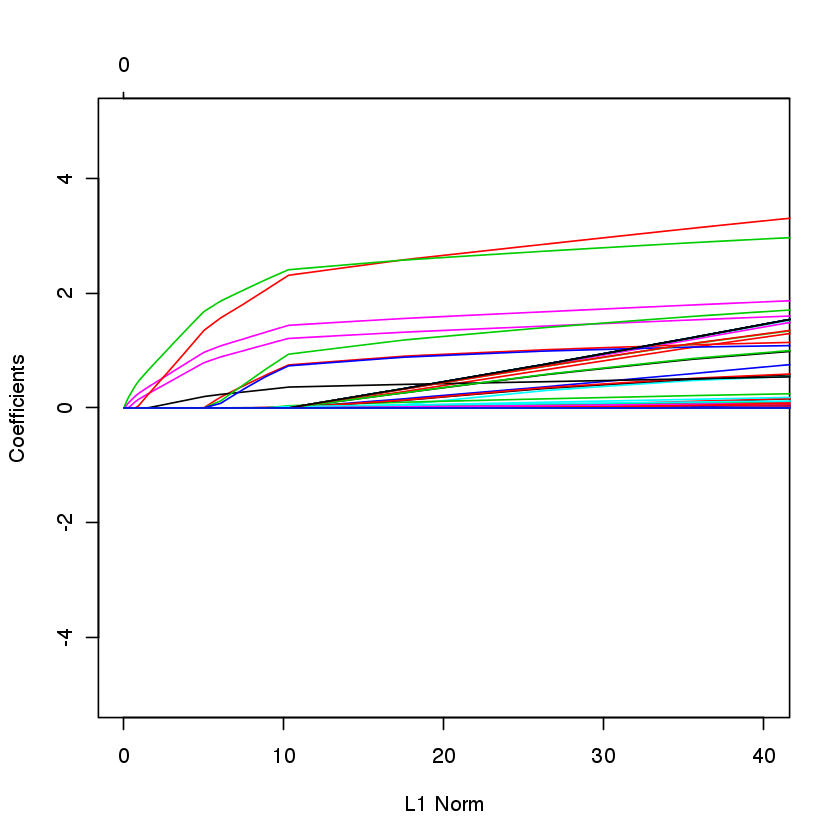

In [5]:
plot(fit.warmup, label=TRUE, xlim=c(0, 40), ylim=c(-5, 5))

Let's also list the coefficients for models with increasing numbers of coefficients by strobing $\lambda$:

In [2]:
summary.glmnet <- function(x, fit, s) {
    fit.summary <- summary(coef(fit, s = s, exact = FALSE))
    fit.summary[, 4] <- c("Intercept", colnames(x))[fit.summary[, 1]]
    fit.summary[, 5] <- sapply(fit.summary[, 4], de_code)
    fit.summary <- fit.summary[order(-abs(fit.summary[, 3])),]
    colnames(fit.summary)[3:5] <- c("coeff", "input var", "code description")
    rownames(fit.summary) <- NULL
    fit.summary <- fit.summary[3:5]
    fit.summary
}

In [7]:
lapply(list(1.5, 0.5, 0.25), function(s) {
    summary.glmnet(mat4, fit.warmup, s)
})

[[1]]
 
         coeff                              input var
1 -5.685042753                              Intercept
2  0.024131575 abnormal_labs:4730-C.DIFF. TOXIN B PCR
3  0.005069246               meds_administered:300025
                                     code description
1                                                    
2                                                    
3 VANCOMYCIN ORAL LIQUID REPACKAGE ONLY - 125MG/2.5ML

[[2]]
 
        coeff                              input var
1 -5.68783227                              Intercept
2  1.08143416 abnormal_labs:4730-C.DIFF. TOXIN B PCR
3  0.68535277          abnormal_labs:4647-C.DIFF EIA
4  0.61209966               meds_administered:300025
5  0.46915661                    problem_list:008.45
6  0.08274214                 meds_administered:5484
                                     code description
1                                                    
2                                                    
3                                                    
4 VANCOMYCIN ORAL LIQUID REPACKAGE ONLY - 125MG/2.5ML
5   Intestinal infection due to Clostridium difficile
6                            METRONIDAZOLE 250 MG TAB

[[3]]
 
          coeff                              input var
1  -5.708743505                              Intercept
2   2.364778692 abnormal_labs:4730-C.DIFF. TOXIN B PCR
3   2.246024525          abnormal_labs:4647-C.DIFF EIA
4   1.409927678               meds_administered:300025
5   1.184625719                    problem_list:008.45
6   0.867875302                 meds_administered:4074
7   0.702563669                   meds_reported:300025
8   0.684303990               meds_administered:300092
9   0.352851395                 meds_administered:5484
10  0.029480913                    meds_reported:13623
11  0.019934167               meds_administered:400740
12  0.017305290                    problem_list:787.91
13  0.009814113                         length_of_stay
14  0.006610643                 meds_administered:6295
15  0.005305506                 meds_administered:8256
16  0.002340640                 meds_administered:3474
                                                         code description
1                                                                        
2                                                                        
3                                                                        
4                     VANCOMYCIN ORAL LIQUID REPACKAGE ONLY - 125MG/2.5ML
5                       Intestinal infection due to Clostridium difficile
6                                         PROMETHAZINE 6.25 MG/5 ML SYRUP
7                     VANCOMYCIN ORAL LIQUID REPACKAGE ONLY - 125MG/2.5ML
8                                                        VANCOMYCIN ENEMA
9                                                METRONIDAZOLE 250 MG TAB
10                                                  VANCOMYCIN 250 MG CAP
11                                FOSAPREPITANT 150/DEX 12/ZOFRAN 8 COMBO
12                                                               Diarrhea
13                                                                       
14 METRONIDAZOLE IN SODIUM CHLORIDE (ISO-OSM) 500 MG/100 ML IV PIGGY BACK
15                                                ACYCLOVIR 800 MG TABLET
16                                       NYSTATIN 100,000 UNIT/G OINTMENT

Unsurprisingly, as we see above and in the plot of coefficients vs. L1 norm, the most "valuable" input variables are the `problem_list` entry of `008.45`, positive PCR and EIA toxin assays, and medications that are clearly treatments for CDI (oral vanco and metronidazole). So the good news is that the ICD-9 CDI billing code is easy to assign with machine learning methods, even when blinded to info past the first 24h of the visit. But as far as a propensity model is concerned, this is cheating.

What's nice is we also see other sensible correlates:

- the weakly positive correlation with `length_of_stay`, which we kept in the training data for this round, even though the outcome variable *must* be hidden when propensity matching (see [Stuart, *Statistical Science*, 2010](http://biostat.jhsph.edu/~estuart/Stuart10.StatSci.pdf)).
- the problem list ICD9 code `787.91` for "diarrhea", which we probably need to exclude since it's a symptom of existing CDI

Let's furthermore test the optimization of $\lambda$ via five-fold cross-validation and maximization of area under the receiver operating characteristic (AUROC or AUC). This is a standard feature of the `glmnet` library.

Every time we do a `cv.glmnet()` note that this takes at least a few minutes.

In [8]:
cvfit.warmup <- cv.glmnet(mat4, df$cdi_dx, family="binomial", alpha=0.01, parallel=TRUE, nfolds=5, type.measure="auc")

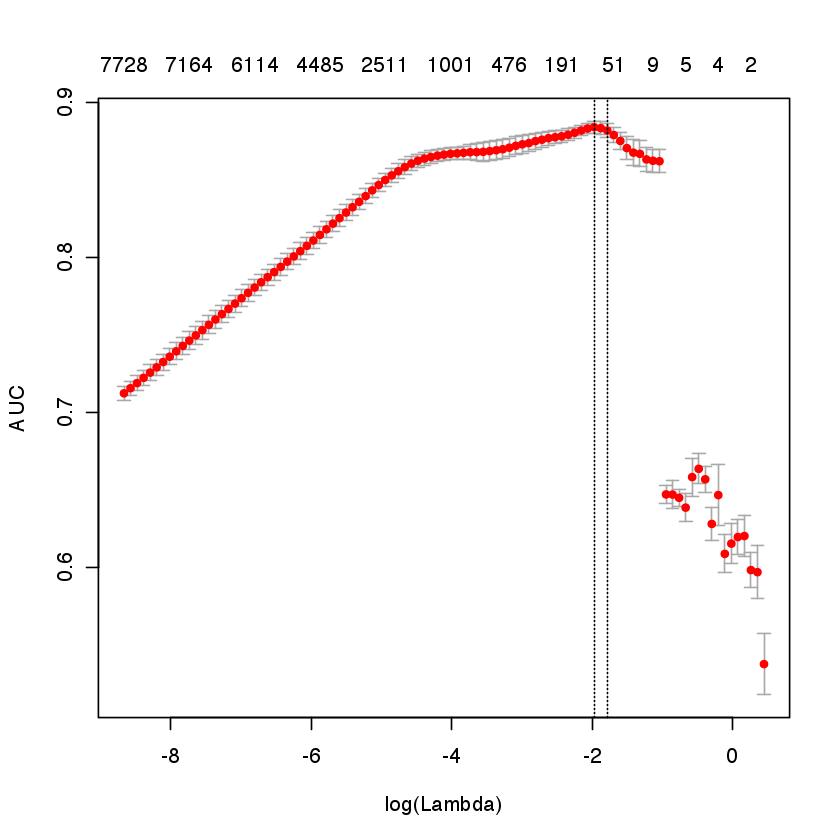

In [9]:
plot(cvfit.warmup)

The performance of this model is very good; the following shows the maximal mean AUC seen during the above optimization.

In [10]:
max(cvfit.warmup$cvm)

[1] 0.8838947

In [11]:
summary.glmnet(mat4, cvfit.warmup, "lambda.min")

coeff         input var                                 
1  -5.7731781    Intercept                                 
2   3.9045253    abnormal_labs:4647-C.DIFF EIA             
3   3.2565696    abnormal_labs:4730-C.DIFF. TOXIN B PCR    
4   2.7182434    meds_reported:1692                        
5   2.7181130    problem_list:209.26                       
6   2.7150157    meds_reported:37860                       
7   2.7143354    abnormal_labs:4311-BACT Ag ST.PNEUMO.     
8   2.7109911    meds_reported:96857                       
9   2.6748533    meds_reported:19850                       
10  2.6582668    meds_reported:54995                       
11  2.6490898    meds_reported:46547                       
12  2.6007631    meds_reported:95567                       
13  2.5152970    meds_reported:77795                       
14  2.4208002    problem_list:477.1                        
15  2.1201252    meds_administered:300025                  
16  2.0683199    meds_administered:4074                    
17  2.0087529    meds_reported:26285                       
18  1.9989717    meds_administered:400337                  
19  1.9805295    meds_administered:400916                  
20  1.8395875    problem_list:008.45                       
21  1.3629916    meds_administered:3866                    
22  1.3523397    meds_reported:13640                       
23  1.3382344    problem_list:203.10                       
24  1.2384226    meds_reported:300025                      
25  1.1152503    meds_administered:300092                  
26  0.8009179    meds_reported:19143                       
27  0.7963937    meds_reported:36581                       
28  0.6972804    problem_list:V02.3                        
29  0.6662901    meds_administered:5484                    
30  0.6159933    problem_list:730.21                       
⋮  ⋮             ⋮                                         
60  0.1643518366 meds_administered:65996                   
61  0.1447412024 meds_reported:6295                        
62  0.1397115421 meds_administered:400183                  
63  0.1238820192 meds_reported:37780                       
64  0.1231111068 meds_administered:3474                    
65  0.1205465780 problem_list:787.91                       
66  0.1134472233 meds_administered:17145                   
67  0.1132303246 meds_reported:97819                       
68  0.1005318037 meds_administered:300040                  
69  0.0956303318 meds_administered:105813                  
70  0.0948052880 meds_administered:4432                    
71  0.0870275146 meds_administered:17041                   
72  0.0618150699 meds_reported:747                         
73  0.0555457749 problem_list:558.9                        
74  0.0488699655 meds_reported:9542                        
75  0.0482016406 meds_reported:6870                        
76  0.0478302693 meds_administered:6295                    
77  0.0352373175 length_of_stay                            
78  0.0313605560 problem_list:556.9                        
79  0.0295269975 meds_administered:5093                    
80  0.0097714495 meds_administered:3641                    
81  0.0088237008 meds_administered:400284                  
82  0.0078313750 meds_administered:36912                   
83 -0.0077366762 admission_sources:Non Health Care Facility
84  0.0047428153 abnormal_labs:1140-PROTEIN TOTAL          
85  0.0044462213 problem_list:203.00                       
86  0.0031219696 admission_sources:Emergency Room          
87  0.0023113724 abnormal_labs:1105-ALBUMIN                
88  0.0009929592 meds_administered:16822                   
89  0.0002176837 problem_list:204.00                       
   code description                                                      
1                                                                        
2                                                                        
3                                                            

We only need 48 parameters to achieve AUC=0.87, which makes sense since very close correlates (the diagnostic labs for CDI, the problem list code, etc.) were mixed into the inputs.

### Fairer model with close correlates hidden

In order to do propensity model correctly, we must force the model to learn without having access to columns that are a direct correlate for CDI or the diagnosis thereof (i.e. pathognomonic or nearly so, or part of the standard workup and treatment).

What do we exclude? Well, based on the above exercise, and correlates that were observed in the prior version of this analysis, we are going to exclude the following.

- `problem_list:008.45` - Intestinal infection due to Clostridium difficile
- `abnormal_labs:4730-C.DIFF. TOXIN B PCR`
- `abnormal_labs:4647-C.DIFF EIA`
- `abnormal_labs:4647-C.DIFF EIA TOXIN A&B`
- `meds_administered:300025` - VANCOMYCIN ORAL LIQUID REPACKAGE ONLY - 125MG/2.5ML
- `meds_administered:63653` - VANCOMYCIN ORAL
- `meds_administered:8200` - VANCOMYCIN 125 MG CAP
- `meds_administered:14246` - VANCOMYCIN 250 MG/5 ML ORAL SOLUTION
- `meds_administered:300092` - VANCOMYCIN ENEMA
- `meds_administered:13623` - VANCOMYCIN 250 MG CAP
- `meds_administered:5484` - METRONIDAZOLE 250 MG TAB
- `meds_administered:54227` - METRONIDAZOLE ORAL
- `meds_administered:6870` - METRONIDAZOLE 500 MG TAB
- `meds_administered:5484` - METRONIDAZOLE 250 MG TAB
- `meds_administered:6295` - METRONIDAZOLE IN SODIUM CHLORIDE (ISO-OSM) 500 MG/100 ML IV PIGGY BACK
- `meds_administered:400648` - METRONIDAZOLE 250 MG/50 ML ISO-OSMOTIC SOLUTION
- `meds_administered:1527` - METRONIDAZOLE HCL 500 MG IV SOLUTION
- `meds_administered:19702` - METRONIDAZOLE 375 MG CAP
- `meds_administered:300009` - METRONIDAZOLE 50 MG/ML ORAL SUSP
- `meds_administered:400660` - METRONIDAZOLE 750 MG/150 ML ISO-OSMOTIC SOLUTION
- *All the above meds* in `meds_reported:` as well
- `problem_list:041.84` - Other specified bacterial infections in conditions classified elsewhere and of unspecified site, other anaerobes
- `problem_list:V07.0` - Need for isolation
- `problem_list:V02.3` - Carrier or suspected carrier of other gastrointestinal pathogens
- `problem_list:787.91` - Diarrhea

Note that we exclude oral vancomycin and vanco enemas but allow IV vancomycin, while we exclude both oral and IV metronidazole (but allow topical gels or creams).

We also hide the columns that contain the output variable of interest, `length_of_stay`, since you're not supposed to show it to your propensity scoring model ([Stuart 2010](http://biostat.jhsph.edu/~estuart/Stuart10.StatSci.pdf)). 

In [12]:
excluded_cols <- c('length_of_stay', 'problem_list:008.45', 'abnormal_labs:4730-C.DIFF. TOXIN B PCR',
                   'abnormal_labs:4647-C.DIFF EIA', 'abnormal_labs:4647-C.DIFF EIA TOXIN A&B',
                   'problem_list:041.84', 'problem_list:V07.0', 'problem_list:V02.3', 'problem_list:787.91')
excluded_meds <- c(300025, 63653, 8200, 14246, 300092, 13623, 5484, 54227, 6870, 5484, 6295, 400648, 1527, 19702, 300009, 400660)
excluded_cols <- c(excluded_cols, sapply(excluded_meds, function(x) { paste0('meds_administered:', x) }))
excluded_cols <- c(excluded_cols, sapply(excluded_meds, function(x) { paste0('meds_reported:', x) }))

sum(!(colnames(mat4) %in% excluded_cols))
ncol(mat4)

[1] 23929

[1] 23968

In [13]:
mat4.no_cdi_equivs <- mat4[,!(colnames(mat4) %in% excluded_cols)]
str(mat4.no_cdi_equivs)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:3545569] 0 1 2 3 4 5 6 7 8 9 ...
  ..@ p       : int [1:23930] 0 171938 273902 273904 343875 343876 512570 515814 565720 656276 ...
  ..@ Dim     : int [1:2] 171938 23929
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:23929] "age" "gender:Female" "gender:Indeterminant" "gender:Male" ...
  ..@ x       : num [1:3545569] 80 44 22 52 30 69 66 33 85 21 ...
  ..@ factors : list()


`mat4.no_cdi_equivs` is now the matrix of masked training data appropriate for propensity modeling.

We could just assume $\alpha=0.01$ because it performed well in the last version of the analysis, and it would work here too...

    cvfit.cdi_dx <- cv.glmnet(mat4.no_cdi_equivs, df$cdi_dx, family="binomial", alpha=0.01, parallel=TRUE, nfolds=5, type.measure="auc")

... but to select it empirically, we should maximize AUC while grid-searching for $\alpha$ alongside $\lambda$. From the `glmnet` manual:

> If users would like to cross-validate `alpha` as well, they should call `cv.glmnet` with a pre-computed vector `foldid`, and then use this same fold vector in separate calls to `cv.glmnet` with different values of `alpha`. 

The side benefit of this is that precomputing `foldid` will make the following steps deterministic (so AUC and the models won't change for re-runs).

`cv.glmnet` complains that the models don't converge for most $\lambda$ values when $\alpha > 0.2$, so we only consider the lower end of the range, which is closer to ridge regression than LASSO.

**Warning:** the following is *expensive*, to the tune of half-hour to an hour.

In [14]:
set.seed(82588)
foldid <- sample(cut(seq(1, length(df$cdi_dx)), breaks=5, labels=FALSE))
alphas <- c(0, 0.003, 0.01, 0.03, 0.06, 0.1, 0.15)

In [15]:
cvfits.cdi_dx <- list()
for (alpha in alphas) {
    message("CV-fitting model for all lambdas with alpha = ", alpha)
    cvfits.cdi_dx[[length(cvfits.cdi_dx)+1]] <- cv.glmnet(mat4.no_cdi_equivs, df$cdi_dx, family="binomial", alpha=alpha, 
                                                          parallel=TRUE, foldid=foldid, type.measure="auc")
}
names(cvfits.cdi_dx) <- alphas[1:length(cvfits.cdi_dx)]

CV-fitting model for all lambdas with alpha = 0
CV-fitting model for all lambdas with alpha = 0.003
CV-fitting model for all lambdas with alpha = 0.01
CV-fitting model for all lambdas with alpha = 0.03
CV-fitting model for all lambdas with alpha = 0.06
CV-fitting model for all lambdas with alpha = 0.1
CV-fitting model for all lambdas with alpha = 0.15


ERROR: Error in predmat[which, seq(nlami)] = preds: replacement has length zero


Note that the final error indicates that $\alpha = 0.15$ did not converge.

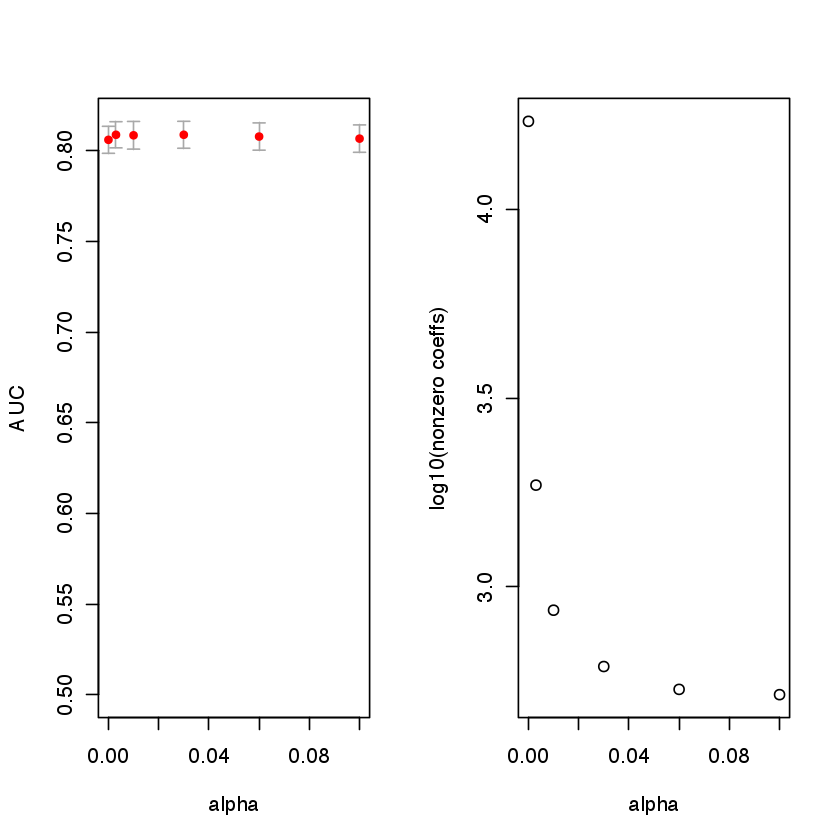

In [85]:
plot.cvfits.alphas <- function(cvfits) {
    alphas <- as.numeric(names(cvfits))
    cvfits.best <- lapply(cvfits, function(cvfit) {
        lambda_i <- match(cvfit$lambda.min, cvfit$lambda)
        c(cvfit$cvm[[lambda_i]], cvfit$cvup[[lambda_i]], cvfit$cvlo[[lambda_i]], cvfit$nzero[[lambda_i]])
    })
    cvfits.best <- matrix(unlist(cvfits.best), ncol=4, byrow=TRUE)
    par(mfrow=c(1, 2))
    
    plot(alphas, cvfits.best[,1], ylim=range(c(0.5, cvfits.best[,2:3])), xlab="alpha", ylab="AUC", type="n")
    arrows(alphas, cvfits.best[,2], alphas, cvfits.best[,3], col = "darkgrey", length=0.05, angle=90, code=3)
    points(alphas, cvfits.best[,1], col="red", pch=20)
    
    plot(alphas, log10(cvfits.best[, 4]), xlab="alpha", ylab="log10(nonzero coeffs)")
}

#pdf("data/analysis_3_selecting_alpha.pdf", width=6, height=4.5)
plot.cvfits.alphas(cvfits.cdi_dx)
#dev.off()

From the above we can see that basically any $\alpha ≤ 0.1$ is equivalent in terms of performance (AUC).

Since it provides a good balance between shrinkage (# of variables pruned—model size within 20% of the size of the smallest model) and AUC, we select $\alpha = 0.03$.

In [17]:
alpha <- 0.03
cvfit.cdi_dx <- cvfits.cdi_dx[[as.character(alpha)]]

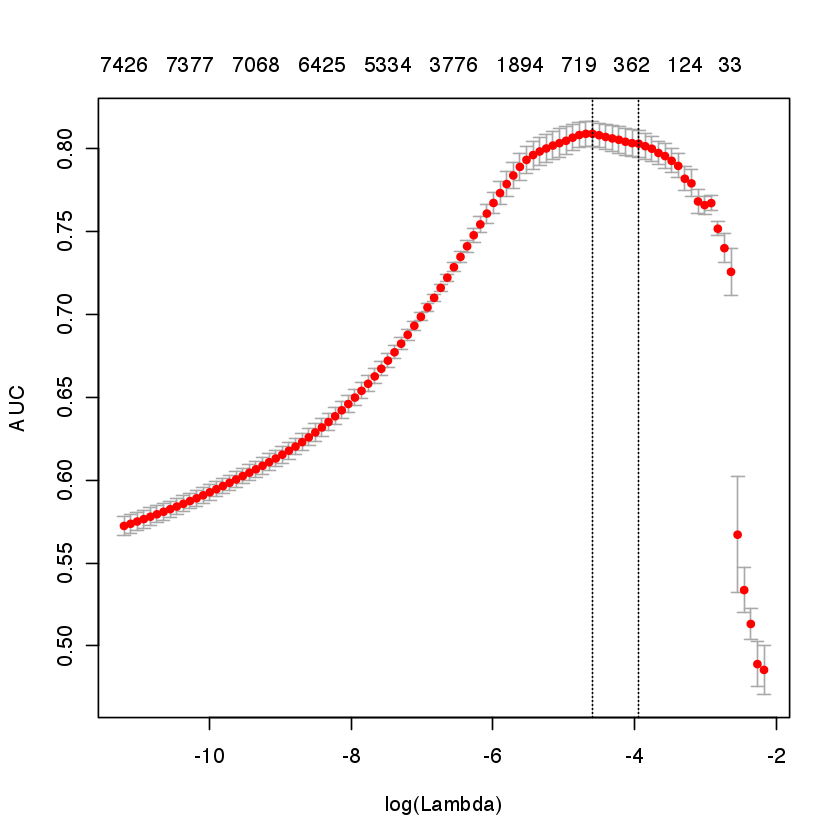

In [86]:
#pdf("data/analysis_3_cvfit-cdi_dx.pdf", width=6, height=4.5)
plot(cvfit.cdi_dx)
#dev.off()

This is the search for $\lambda$ using the data appropriate for a propensity model for `cdi_dx == 'Y'`. We can achieve an AUC of ~0.75 from ~40 coefficients, and it looks like the best model achieves an AUC of ~0.8 with ~1k parameters.

In [19]:
max(cvfit.cdi_dx$cvm)
nrow(summary.glmnet(mat4.no_cdi_equivs, cvfit.cdi_dx, "lambda.min"))
summary.glmnet(mat4.no_cdi_equivs, cvfit.cdi_dx, "lambda.min")

[1] 0.8089329

[1] 616

coeff         input var                                      
1    7.608019     problem_list:209.26                            
2    7.194930     meds_reported:96857                            
3    6.801170     meds_administered:4074                         
4    6.761065     meds_reported:1692                             
5    6.677819     meds_administered:65996                        
6    6.512075     abnormal_labs:4311-BACT Ag ST.PNEUMO.          
7    6.366725     meds_reported:95567                            
8    6.358392     problem_list:477.1                             
9   -6.146771     Intercept                                      
10   6.090526     meds_reported:19850                            
11   6.024313     meds_reported:37860                            
12   5.798464     meds_reported:26285                            
13   5.460958     meds_reported:77795                            
14   5.271598     meds_reported:46547                            
15   5.084146     meds_reported:44687                            
16   4.908824     problem_list:536.49                            
17   4.799771     problem_list:839.00                            
18   4.688895     problem_list:730.21                            
19   4.658002     meds_reported:19525                            
20   4.550279     problem_list:491.8                             
21   4.544181     problem_list:374.34                            
22   4.481249     problem_list:756.17                            
23   4.242421     problem_list:364.41                            
24   4.098065     meds_reported:64228                            
25   4.031864     meds_reported:6373                             
26   4.019555     problem_list:666.12                            
27   3.999840     problem_list:201.50                            
28   3.936282     meds_reported:37763                            
29   3.935325     meds_reported:42030                            
30   3.821769     meds_reported:48350                            
⋮   ⋮             ⋮                                              
587 -0.0167626460 meds_administered:9554                         
588 -0.0166099366 abnormal_labs:3279-WB GLUCOSE-VEN (GEM - MPOCT)
589 -0.0150444759 admission_sources:Physician Referral           
590 -0.0150414280 admission_sources:Clinic                       
591 -0.0146274331 problem_list:786.05                            
592  0.0144154857 abnormal_labs:2655-BASOPHIL %                  
593  0.0142628065 problem_list:724.8                             
594 -0.0141541429 problem_list:V22.1                             
595  0.0132048241 problem_list:733.01                            
596  0.0130486924 problem_list:372.53                            
597 -0.0128520909 problem_list:278.00                            
598  0.0126214433 problem_list:428.22                            
599 -0.0116771585 problem_list:272.4                             
600  0.0110425974 meds_reported:11398                            
601 -0.0103116819 problem_list:V22.0                             
602 -0.0102942517 abnormal_labs:3277-WB GLUCOSE-ART (POCT)       
603 -0.0095877956 abnormal_labs:1074-CK-MB MASS                  
604 -0.0095457774 problem_list:414.00                            
605  0.0092378816 problem_list:202.80                            
606  0.0088651538 abnormal_labs:1131-MAGNESIUM                   
607  0.0074434905 abnormal_labs:106-WB UREA NITROGEN-VEN         
608  0.0062393852 meds_administered:1475                         
609  0.0055678895 problem_list:097.9                             
610  0.0044025679 meds_administered:73300                        
611 -0.0041996177 abnormal_labs:3279-WB GLUCOSE-VEN (POCT)       
612  0.0035226978 abnormal_labs:105-WB CO2 - VEN                 
613  0.0034536623 problem_list:782.3                             
614  0.0021938838 abnormal_labs:3317-O2 SATURATION - VEN         
615  0.0020550510 abnormal_labs:1138-POTASSI

Plenty of interesting correlates in that list...
  
It's also interesting to see the scheduled surgery cases that made it into the model.

In [20]:
cvfit.cdi_dx.lambda_min.summary <- summary.glmnet(mat4.no_cdi_equivs, cvfit.cdi_dx, "lambda.min")
cvfit.cdi_dx.lambda_min.summary[grep("^surgery_cases:", cvfit.cdi_dx.lambda_min.summary[, 2]), ]

coeff     input var                                             
33  3.7099129 surgery_cases:BONE MARROW HARVEST                     
62  3.0888612 surgery_cases:EXAMINATION UNDER ANES PELVIC           
80  2.5787483 surgery_cases:ROUX-EN-Y CHOLEJEJU                     
114 2.0615389 surgery_cases:BURR HOLES/EVAC HEMATOMA                
134 1.7883140 surgery_cases:COLONOSCOPY\\BIOPSY\\BRUSHING           
174 1.2777866 surgery_cases:COLON RESECTION                         
176 1.2558545 surgery_cases:FLEXIBLE SIGMOIDOSCOPY                  
216 0.9442420 surgery_cases:VENOUS ACCESS INS/ADULT/GS              
225 0.9061682 surgery_cases:FLEXIBLE SIGMOIDOSCOPY\\BIOPSY\\BRUSHING
227 0.8910540 surgery_cases:ILEOSTOMY/LAPAROSCOPY                   
247 0.7803910 surgery_cases:ESOPHAGECTOMY                           
276 0.6445026 surgery_cases:CYSTECTOMY+ILEALCONDUIT                 
313 0.5192671 surgery_cases:VENOUS ACCESS INS/ADULT/VASC            
532 0.0633288 surgery_cases:CHOLECYSTECTOMY                         
    code description
33                  
62                  
80                  
114                 
134                 
174                 
176                 
216                 
225                 
227                 
247                 
276                 
313                 
532

The top coefficients by magnitude aren't necessarily the most "valuable" variables for the model in terms of performance. The magnitudes are correlated instead with the odds ratio for each particular variable, but many of these variables are sparse, so the ratios have high variance. Instead, if we back up on the AUC frontier while adjusting $\lambda$, we'll see into the models that were forced to select for fewer variables:

In [21]:
options(digits=3)
lapply(list(5, 40), function(nzero) {
    closest_lambda <- cvfit.cdi_dx$lambda[[findInterval(nzero, cvfit.cdi_dx$nzero[1:50])]]
    summary.glmnet(mat4.no_cdi_equivs, cvfit.cdi_dx, closest_lambda)
})

[[1]]
 
    coeff                input var                        code description
1 -5.6852                Intercept                                        
2  2.4886   meds_administered:4074         PROMETHAZINE 6.25 MG/5 ML SYRUP
3  0.0365 meds_administered:400740 FOSAPREPITANT 150/DEX 12/ZOFRAN 8 COMBO

[[2]]
 
      coeff                                  input var
1  -5.68803                                  Intercept
2   4.11147                     meds_administered:4074
3   2.46828                        problem_list:209.26
4   2.46828                        meds_reported:26285
5   2.46639                        meds_reported:19850
6   2.46639                        meds_reported:77795
7   2.46639                         meds_reported:1692
8   2.46639                        meds_reported:96857
9   2.46639                        meds_reported:37860
10  2.46639                        meds_reported:95567
11  2.46531                        meds_reported:46547
12  2.46531                        meds_reported:54995
13  2.46531                    meds_administered:65996
14  2.46531      abnormal_labs:4311-BACT Ag ST.PNEUMO.
15  2.44837                         problem_list:477.1
16  1.68313                        meds_reported:19143
17  1.68313                   meds_administered:400337
18  1.68313                     meds_administered:3866
19  1.68211                        meds_reported:39806
20  1.66221                        meds_reported:13640
21  1.66221                   meds_administered:400916
22  1.66221                        meds_reported:36581
23  1.66110                        meds_reported:14104
24  1.20971                        problem_list:203.10
25  0.22388                        meds_reported:37780
26  0.22102                   meds_administered:400740
27  0.16039                     meds_administered:8256
28  0.15584                     meds_administered:4033
29  0.11261                   meds_administered:400183
30  0.11125                     meds_administered:3474
31  0.09279                    meds_administered:17145
32  0.07721                    meds_administered:17041
33  0.06360                   meds_administered:300040
34  0.05344                         problem_list:556.9
35  0.02187                         problem_list:558.9
36  0.01799                     meds_administered:4432
37  0.01026                         meds_reported:9542
38 -0.00512 admission_sources:Non Health Care Facility
39  0.00292                   meds_administered:400284
                                                         code description
1                                                                        
2                                         PROMETHAZINE 6.25 MG/5 ML SYRUP
3            Malignant carcinoid tumor of midgut, not otherwise specified
4                              NUT.TX.GLUC.INTOL,LAC-FREE,REG ORAL LIQUID
5                                               CIPROFLOXACIN 10 MG/ML IV
6                                                  HYDROMORPHONE (PF) INJ
7                                            DIOVAN HCT 80 MG-12.5 MG TAB
8                         CEFTAROLINE FOSAMIL 600 MG INTRAVENOUS SOLUTION
9                                          HALOPERIDOL 5 MG/ML IM SYRINGE
10            GLUCAGON (HUMAN RECOMBINANT) 1 MG/ML SOLUTION FOR INJECTION
11                                      DAILY MULTIPLE VITAMINS/IRON ORAL
12                                          MVI, ADULT NO.1 WITH VIT K IV
13 HEPATITIS B IMMUNE GLOBULIN-MALTOSE >312 UNIT/ML (5 ML) INJECTION SOLN
14                                                                       
15                                          Allergic rhinitis due to food
16 AZTREONAM 2 GRAM/50 ML IN DEXTROSE (ISO-OSMOTIC) INTRAVENOUS PIGGYBACK
17                                                    GANCICLOVIR SYRINGE
18                                                 AMOXAPINE 50 MG TABLET
19          COD LIVER OIL-VITAMINS A & D-PETROLATUM 96 % TOPICAL OINTMENT
20 

None of these loudly indicate "the model is cheating," as in the variables are not clear effects or direct correlates of CDI, so I think we're OK. The one that is most arguable is "SACCHAROMYCES BOULARDII 250 MG CAPSULE," which is a probiotic, but it is indicated for many digestive problems (including parenteral nutrition), not just CDI.

"PROMETHAZINE" is given before and after surgery as a sedative and anti-emetic, so this could be a general correlate for certain surgery cases.

Let's keep the top-scoring model at `lambda.min`.  To demonstrate its performance graphically, we can plot the ROC curve, using the [ROCR](http://rocr.bioinf.mpi-sb.mpg.de/) package.

- Note that to calculate the confidence interval for the ROC curve, we iterate through the same folds used for cross-validation by `cv.glmnet`. For each fold, we use it as a test for a model fit to all the other folds, but the $\lambda$ for that model is obtained by a *nested* round of five-fold cross validation.

- Bootstrapping within the final vector of predictions, wherein each prediction is from a model that never had access to the corresponding training data, is used to estimate variance of the ROC curve.

- The ROC curve reflects the performance of the model during cross-validation, out of concern for only evaluating the model on data not shown to it in training, *but* the model that is used going forward for propensity score matching (fit to the entirety of `x`) may in fact have slightly better performance.

In [3]:
require(ROCR)

perf.glmnet <- function(x, truth, fit, foldid, s="lambda.min", alpha=0.1, boot.n=100) {
    if (!is.character(s)) {
        stop("s can only be 'lambda.1sd' or 'lambda.min' because the model will be refit for each fold and lambda changes.")
    }
    reps <- boot.n
    if (is.matrix(x) | class(x) == 'dgCMatrix') {
        nfolds <- max(foldid)
        pred <- numeric(length(truth))
        for (fold in 1:nfolds) {
            test_indices <- which(foldid == fold)
            message("Refitting model to calculate CI, fold ", fold, " of ", nfolds)
            fold_fit <- cv.glmnet(x[-test_indices,], truth[-test_indices], family="binomial", parallel=TRUE, nfolds=5, alpha=alpha,
                                  type.measure="auc")
            pred[test_indices] <- predict(fold_fit, type="response", newx=x[test_indices,], s=s)
        }
    } else {
        # Allows performance object to be reconstituted from predictions (saves storage & compute, can re-bootstrap easily)
        pred <- x 
    }

    boot.pred <- matrix(0, nrow=length(truth), ncol=reps)
    boot.truth <- matrix(0, nrow=length(truth), ncol=reps)
    for (rep in 1:reps) {
        bootstrap_indices <- sample(1:length(truth), length(truth), replace=TRUE)
        boot.pred[,rep] <- pred[bootstrap_indices]
        boot.truth[,rep] <- truth[bootstrap_indices] 
    }
    
    pred.obj <- prediction(boot.pred, boot.truth)
    perf <- list(pred=pred,
                 roc=performance(pred.obj, measure="tpr", x.measure="fpr"),
                 acc=performance(pred.obj, measure="acc"),
                 auc=performance(pred.obj, measure="auc"))
    invisible(perf)
}

plotROC <- function(perf, colorize=FALSE, downsampling=100) {
    par(mar=c(4, 4, 2, 2))
    pal <- rich.colors(1000)
    if (length(perf$roc@x.values) > 1) {
        if (colorize) { plot(perf$roc, type="n", avg="threshold", colorkey=TRUE, colorize.palette=pal) }
        plot(perf$roc, col="gray", colorize.palette=pal, downsampling=downsampling, add=colorize, lwd=0.5)
        plot(perf$roc, avg="threshold", colorize=colorize, colorize.palette=pal,
             downsampling=downsampling, lwd=2, add=TRUE)
    } else {
        if (colorize) { plot(perf$roc, type="n", colorkey=TRUE, colorize.palette=pal) }
        plot(perf$roc, colorize=colorize, avg="threshold", downsampling=downsampling, colorize.palette=pal,
             colorkey=TRUE, lwd=2, add=colorize)
    }
    lines(c(-0.2, 1.2), c(-0.2, 1.2), col="gray", lty=2)
}

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [23]:
perf.cdi_dx <- perf.glmnet(mat4.no_cdi_equivs, df$cdi_dx, cvfit.cdi_dx, foldid=foldid, alpha=alpha)

Refitting model to calculate CI, fold 1 of 5
Refitting model to calculate CI, fold 2 of 5
Refitting model to calculate CI, fold 3 of 5
Refitting model to calculate CI, fold 4 of 5
Refitting model to calculate CI, fold 5 of 5


Calculates a 95% CI from the bootstrapped AUCs, using the percentile method.

In [24]:
round(mean(as.numeric(perf.cdi_dx$auc@y.values)), 2)
round(quantile(as.numeric(perf.cdi_dx$auc@y.values), 0.025), 2)
round(quantile(as.numeric(perf.cdi_dx$auc@y.values), 0.975), 2)

[1] 0.81

2.5% 
0.79

97.5% 
 0.83

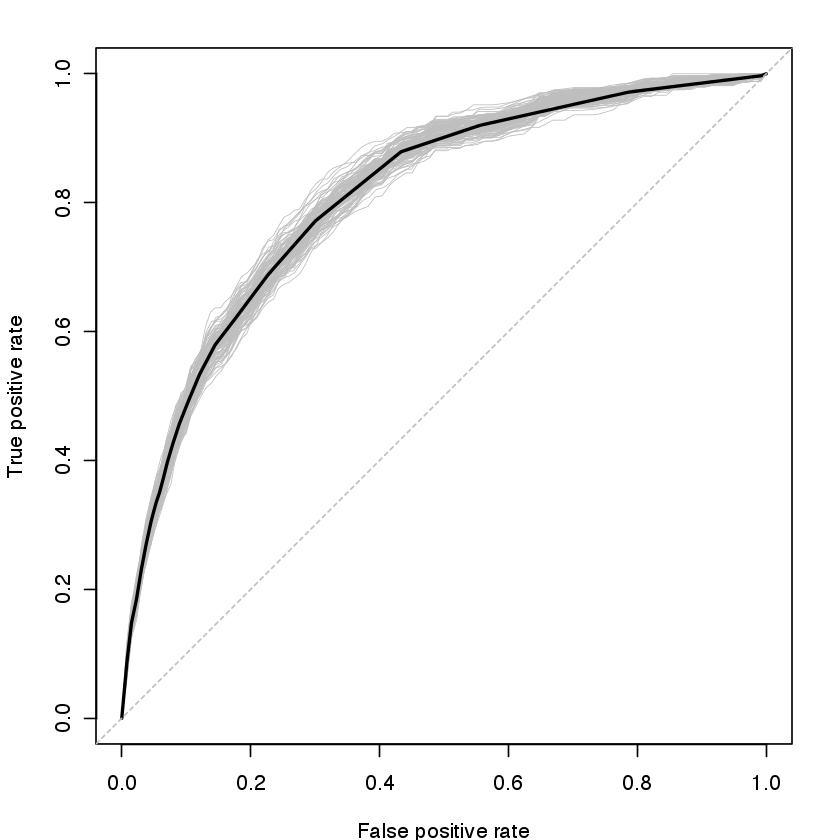

In [88]:
#pdf("data/analysis_3_cvfit-cdi_dx-roc.pdf", width=3.5, height=3.5)
plotROC(perf.cdi_dx, downsampling=100)
#dev.off() 

## 1b. Propensity model for  `cdtox_eia_positive = 'Y'`

OK, now on to the other definitions of CDI based on EMR fields. In this one we were looking for a positive EIA toxin assay result during the visit.

Note that because this toxin assay was only given during the first 2.6 years of the dataset, we train this model on only that part of the data (where `df$started_cdtox_pcr == 'N'`). It would be misleading to treat PCR positives after this timepoint as CDI negatives.

In [27]:
nrow(mat4.no_cdi_equivs[df$started_cdtox_pcr == 'N',])
sum(df$cdtox_eia_positive == 'Y')
sum(df$cdtox_eia_positive[df$started_cdtox_pcr == 'N'] == 'Y')

[1] 73971

[1] 324

[1] 324

In [28]:
set.seed(82588)
foldid.cdtox_eia <- sample(cut(seq(1, sum(df$started_cdtox_pcr == 'N')), breaks=5, labels=FALSE))

cvfit.cdtox_eia <- cv.glmnet(mat4.no_cdi_equivs[df$started_cdtox_pcr == 'N',], df$cdtox_eia_positive[df$started_cdtox_pcr == 'N'],
                             family="binomial", alpha=alpha, parallel=TRUE, foldid=foldid.cdtox_eia, type.measure="auc")

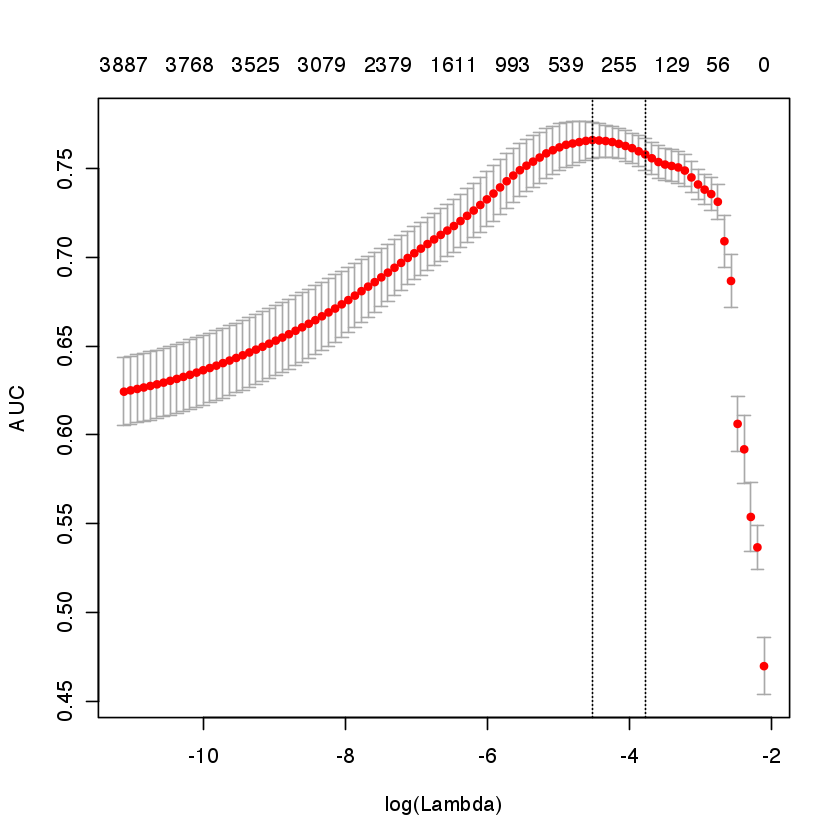

In [92]:
#pdf("data/analysis_3_cvfit-cdtox_eia.pdf", width=6, height=4.5)
plot(cvfit.cdtox_eia)
#dev.off()

Also quite interesting, it seems our maximal score of AUC=0.77 here is reached with more variables (~400).

In [30]:
max(cvfit.cdtox_eia$cvm)
nrow(summary.glmnet(mat4.no_cdi_equivs, cvfit.cdtox_eia, "lambda.min"))

[1] 0.766

[1] 374

The retained parameters at the highest $\lambda$ values were:

In [31]:
lapply(list(20, 40), function(nzero) {
    closest_lambda <- cvfit.cdtox_eia$lambda[[findInterval(nzero, cvfit.cdtox_eia$nzero[1:50])]]
    summary.glmnet(mat4.no_cdi_equivs[df$started_cdtox_pcr == 'N',], cvfit.cdtox_eia, closest_lambda)
})

[[1]]
 
     coeff                            input var
1  -5.4290                            Intercept
2   2.2922                   problem_list:491.8
3   2.2922                   problem_list:269.1
4   2.2922                  problem_list:209.26
5   2.2922                   problem_list:458.8
6   2.2922                  meds_reported:76695
7   2.2922                  meds_reported:63727
8   2.2922                  meds_reported:49448
9   2.2890                  meds_reported:28525
10  2.2890                   meds_reported:2499
11  2.2833                    meds_reported:783
12  1.6252                  meds_reported:79819
13  1.6218                   meds_reported:1692
14  1.6213                  meds_reported:62668
15  1.6178                  meds_reported:20712
16  0.6158 surgery_cases:NEPHRECTOMY/TRANSPLANT
17  0.0286            abnormal_labs:2622-BLASTS
18  0.0104           abnormal_labs:1105-ALBUMIN
                                                      code description
1                                                                     
2                                             Other chronic bronchitis
3                                         Deficiency of other vitamins
4         Malignant carcinoid tumor of midgut, not otherwise specified
5                                          Other specified hypotension
6  PRENATAL VIT WITHOUT CALCIUM-IRON GLUC-FOLIC ACID 30 MG-800 MCG TAB
7                                                           VELCADE IV
8                                                     FLUCONAZOLE ORAL
9                                     MORPHINE (PF) 10 MG/ML INJECTION
10                                         CIPROFLOXACIN 750 MG TABLET
11                                           CLOTRIMAZOLE 10 MG TROCHE
12                                            BRIMONIDINE-TIMOLOL OPHT
13                                        DIOVAN HCT 80 MG-12.5 MG TAB
14                                                       TRAVATAN OPHT
15                                                 DILTIAZEM 90 MG TAB
16                                                                    
17                                                                    
18                                                                    

[[2]]
 
     coeff                            input var
1  -5.4358                            Intercept
2   3.4365                   problem_list:491.8
3   3.4365                   problem_list:269.1
4   3.4365                  problem_list:209.26
5   3.4365                   problem_list:458.8
6   3.4365                  meds_reported:76695
7   3.4365                  meds_reported:49448
8   3.4246                  meds_reported:63727
9   3.4170                   meds_reported:2499
10  3.4051                  meds_reported:28525
11  3.2999                    meds_reported:783
12  2.0856                  meds_reported:79819
13  2.0828                  meds_reported:62668
14  2.0637                   meds_reported:1692
15  2.0608                  meds_reported:20712
16  1.3885 surgery_cases:NEPHRECTOMY/TRANSPLANT
17  0.6654                  problem_list:997.61
18  0.6654                   problem_list:009.1
19  0.6613                  meds_reported:29664
20  0.6237                  meds_reported:56785
21  0.6237                  meds_reported:55088
22  0.1854            abnormal_labs:2622-BLASTS
23  0.1111      abnormal_labs:2621-PROMYELOCYTE
24  0.0444         abnormal_labs:2618-BAND CELL
25  0.0331           abnormal_labs:1105-ALBUMIN
26  0.0202        abnormal_labs:1135-PHOSPHORUS
                                                        code description
1                                                                       
2                                               Other chronic bronchitis
3                                           Deficiency of other vitamins
4           Malignant carcinoid tumor of midgut, not otherwise specified
5                                            Other specified 

Pretty inscrutable, actually. Many of these are not typically what you'd expect for CDI risk based on clinical intuition.

In [32]:
perf.cdtox_eia <- perf.glmnet(mat4.no_cdi_equivs[df$started_cdtox_pcr == 'N',], df$cdtox_eia_positive[df$started_cdtox_pcr == 'N'], 
                              cvfit.cdtox_eia, foldid=foldid.cdtox_eia, alpha=alpha)

Refitting model to calculate CI, fold 1 of 5
Refitting model to calculate CI, fold 2 of 5
Refitting model to calculate CI, fold 3 of 5
Refitting model to calculate CI, fold 4 of 5
Refitting model to calculate CI, fold 5 of 5


In [33]:
round(mean(as.numeric(perf.cdtox_eia$auc@y.values)), 2)
round(quantile(as.numeric(perf.cdtox_eia$auc@y.values), 0.025), 2)
round(quantile(as.numeric(perf.cdtox_eia$auc@y.values), 0.975), 2)

[1] 0.76

2.5% 
0.74

97.5% 
 0.78

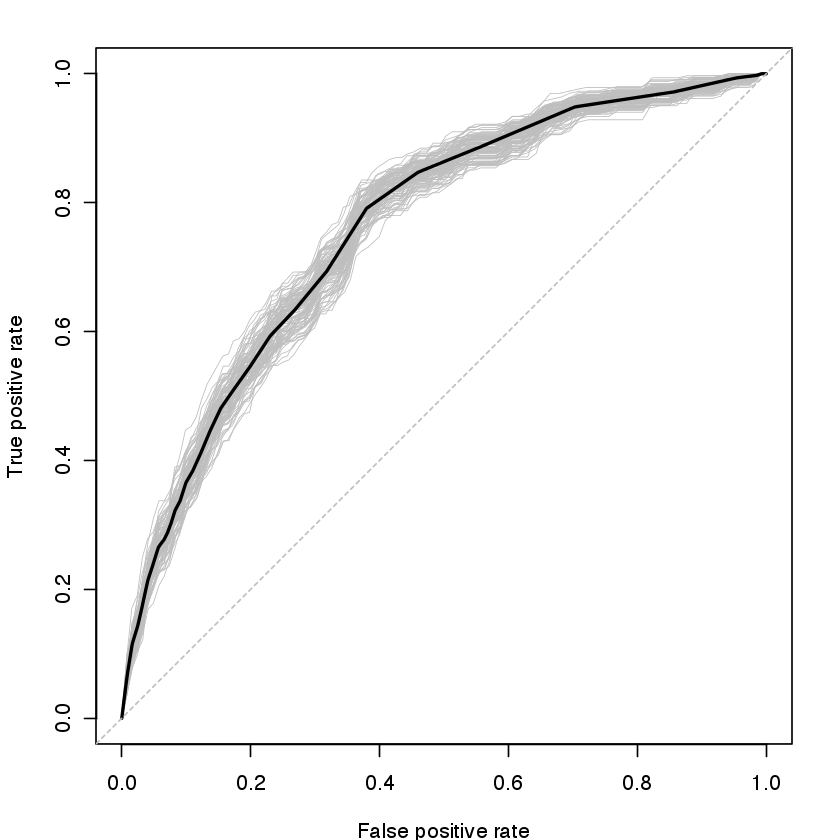

In [90]:
#pdf("data/analysis_3_cvfit-cdtox_eia-roc.pdf", width=3.5, height=3.5)
plotROC(perf.cdtox_eia, downsampling=100)
#dev.off()

## 1c. Propensity model for `cdtox_pcr_positive = 'Y'`

In [35]:
nrow(mat4.no_cdi_equivs[df$started_cdtox_pcr == 'Y',])
sum(df$cdtox_pcr_positive == 'Y')
sum(df$cdtox_pcr_positive[df$started_cdtox_pcr == 'Y'] == 'Y')

[1] 97967

[1] 620

[1] 616

In [36]:
set.seed(82588)
foldid.cdtox_pcr <- sample(cut(seq(1, sum(df$started_cdtox_pcr == 'Y')), breaks=5, labels=FALSE))

cvfit.cdtox_pcr <- cv.glmnet(mat4.no_cdi_equivs[df$started_cdtox_pcr == 'Y',], df$cdtox_pcr_positive[df$started_cdtox_pcr == 'Y'], 
                             family="binomial", alpha=alpha, parallel=TRUE, foldid=foldid.cdtox_pcr, type.measure="auc")

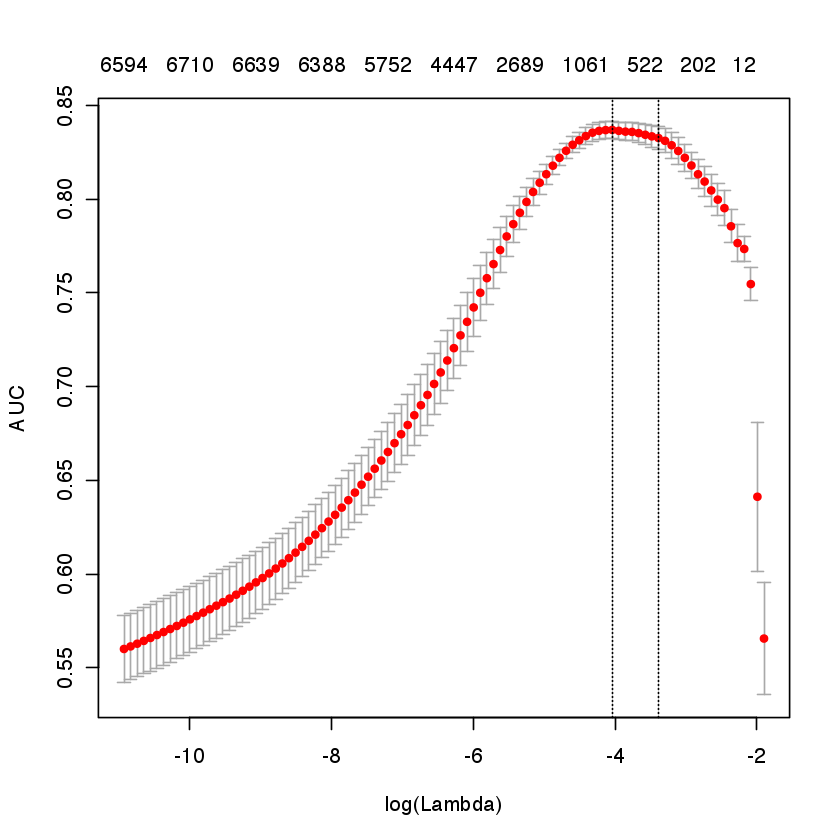

In [94]:
#pdf("data/analysis_3_cvfit-cdtox_pcr.pdf", width=6, height=4.5)
plot(cvfit.cdtox_pcr)
#dev.off()

In [30]:
max(cvfit.cdtox_pcr$cvm)
nrow(summary.glmnet(mat4.no_cdi_equivs, cvfit.cdtox_pcr, "lambda.min"))

[1] 0.836983

[1] 749

In [39]:
lapply(list(5, 30), function(nzero) {
    closest_lambda <- cvfit.cdtox_pcr$lambda[[findInterval(nzero, cvfit.cdtox_pcr$nzero[1:50])]]
    summary.glmnet(mat4.no_cdi_equivs, cvfit.cdtox_pcr, closest_lambda)
})

[[1]]
 
     coeff                  input var                          code description
1 -5.06326                  Intercept                                          
2  0.62651        problem_list:536.49           Other gastrostomy complications
3  0.62651     meds_administered:4074           PROMETHAZINE 6.25 MG/5 ML SYRUP
4  0.00450    meds_administered:17041 NYSTATIN 100,000 UNIT/GRAM TOPICAL POWDER
5  0.00320 abnormal_labs:1105-ALBUMIN                                          
6  0.00151     meds_administered:3474          NYSTATIN 100,000 UNIT/G OINTMENT

[[2]]
 
      coeff                                  input var
1  -5.06648                                  Intercept
2   1.89339                     meds_administered:4074
3   1.89292                        problem_list:536.49
4   0.08136                     meds_administered:3474
5   0.07073                    meds_administered:17041
6   0.06940                    meds_administered:17145
7   0.05178                   meds_administered:300040
8   0.02258                 abnormal_labs:1105-ALBUMIN
9   0.01517                     meds_administered:4432
10  0.00893                 abnormal_labs:250-PRO TIME
11  0.00693                   meds_administered:400284
12 -0.00568 admission_sources:Non Health Care Facility
13  0.00227           abnormal_labs:1140-PROTEIN TOTAL
                                         code description
1                                                        
2                         PROMETHAZINE 6.25 MG/5 ML SYRUP
3                         Other gastrostomy complications
4                        NYSTATIN 100,000 UNIT/G OINTMENT
5               NYSTATIN 100,000 UNIT/GRAM TOPICAL POWDER
6  BACITRACIN-POLYMYXIN B 500 UNIT-10,000 UNIT/G OINTMENT
7                                       GRADE 0 MOUTHWASH
8                                                        
9                               FLUCONAZOLE 200 MG TABLET
10                                                       
11                         SODIUM CHLORIDE 0.9 % IV BOLUS
12                                                       
13

These features are interesting because some of them hint at more complex patients that are likely to stick around in the hospital longer and/or be more susceptible to infections... not NaCl, obviously, but:

- Nystatin suggests cutaneous *Candida*, which suggests diabetes, obesity or immunocompromised status
- Promethazine is an anti-emetic given after surgery, as noted above.

In [40]:
perf.cdtox_pcr <- perf.glmnet(mat4.no_cdi_equivs[df$started_cdtox_pcr == 'Y',], df$cdtox_pcr_positive[df$started_cdtox_pcr == 'Y'], 
                              cvfit.cdtox_pcr, foldid=foldid.cdtox_pcr, alpha=alpha)

Refitting model to calculate CI, fold 1 of 5
Refitting model to calculate CI, fold 2 of 5
Refitting model to calculate CI, fold 3 of 5
Refitting model to calculate CI, fold 4 of 5
Refitting model to calculate CI, fold 5 of 5


In [41]:
round(mean(as.numeric(perf.cdtox_pcr$auc@y.values)), 2)
round(quantile(as.numeric(perf.cdtox_pcr$auc@y.values), 0.025), 2)
round(quantile(as.numeric(perf.cdtox_pcr$auc@y.values), 0.975), 2)

[1] 0.84

2.5% 
0.82

97.5% 
 0.85

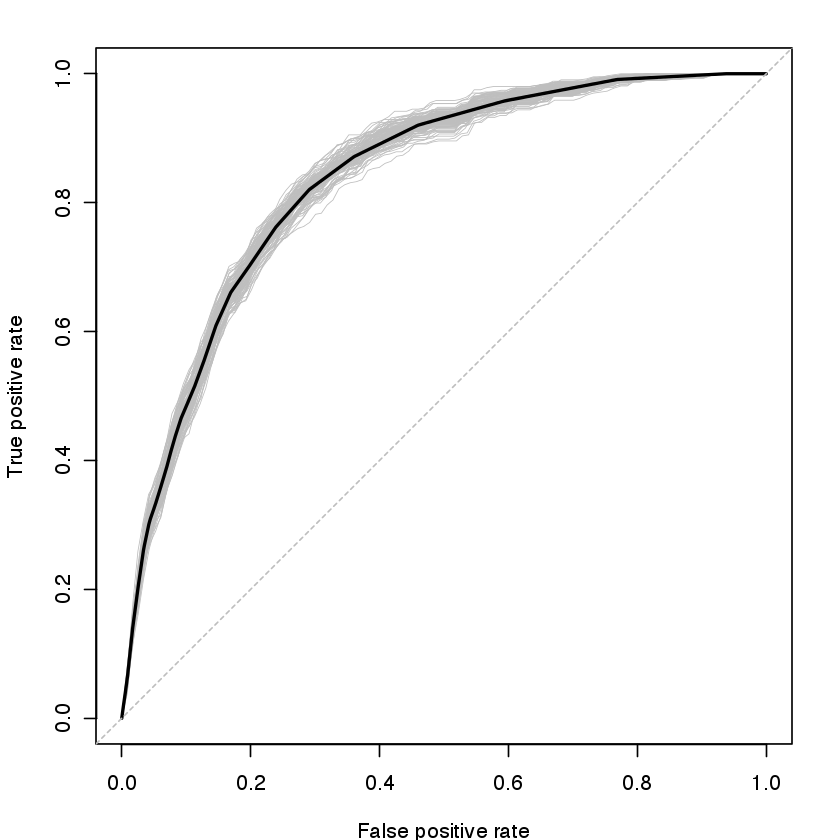

In [96]:
#pdf("data/analysis_3_cvfit-cdtox_pcr-roc.pdf", width=3.5, height=3.5)
plotROC(perf.cdtox_pcr, downsampling=100)
#dev.off()

## 1d. Propensity model for either 1b OR 1c (either PCR or EIA cdtox positive)

In [43]:
cvfit.cdtox_all <- cv.glmnet(mat4.no_cdi_equivs, df$cdtox_pcr_positive == 'Y' | df$cdtox_eia_positive == 'Y',
                             family="binomial", alpha=alpha, parallel=TRUE, foldid=foldid, type.measure="auc")

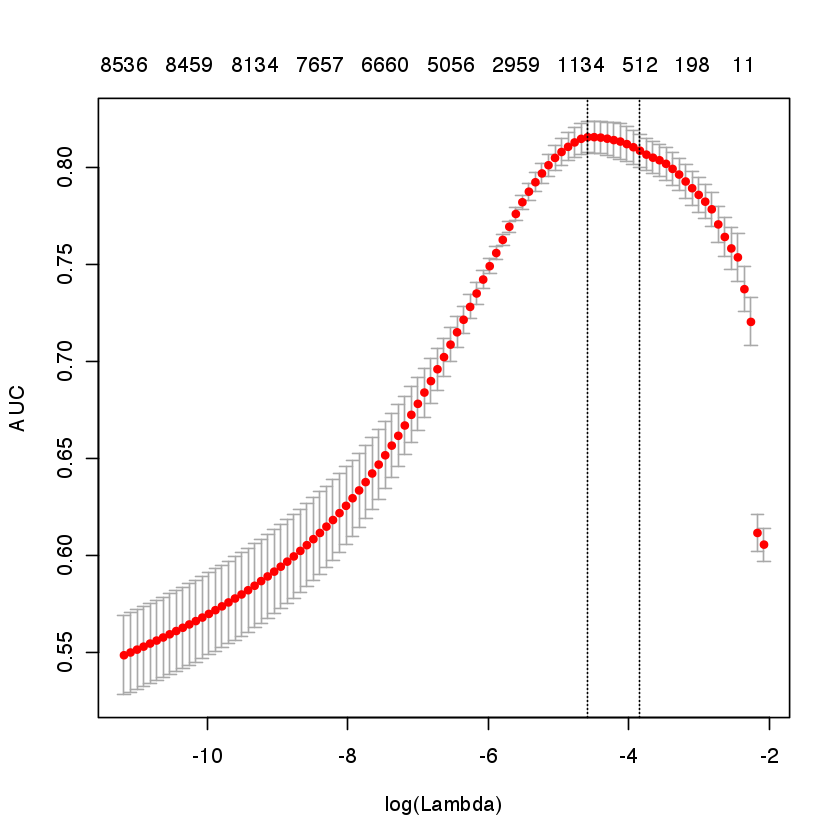

In [98]:
#pdf("data/analysis_3_cvfit-cdtox_all.pdf", width=6, height=4.5)
plot(cvfit.cdtox_all)
#dev.off()

In [31]:
max(cvfit.cdtox_all$cvm)
nrow(summary.glmnet(mat4.no_cdi_equivs, cvfit.cdtox_all, "lambda.min"))

[1] 0.8156241

[1] 1021

In [46]:
lapply(list(7, 30), function(nzero) {
    closest_lambda <- cvfit.cdtox_all$lambda[[findInterval(nzero, cvfit.cdtox_all$nzero[1:50])]]
    summary.glmnet(mat4.no_cdi_equivs, cvfit.cdtox_all, closest_lambda)
})

[[1]]
 
      coeff                                  input var
1 -5.20e+00                                  Intercept
2  6.84e-01                     meds_administered:4074
3  6.84e-01                        problem_list:536.49
4  2.01e-02                 abnormal_labs:1105-ALBUMIN
5 -9.05e-05 admission_sources:Non Health Care Facility
                 code description
1                                
2 PROMETHAZINE 6.25 MG/5 ML SYRUP
3 Other gastrostomy complications
4                                
5                                

[[2]]
 
      coeff                                  input var
1  -5.20277                                  Intercept
2   2.22779                     meds_administered:4074
3   2.22428                        problem_list:536.49
4   0.08766                     meds_administered:3474
5   0.07999                    meds_administered:17041
6   0.06972                    meds_administered:17145
7   0.04944                   meds_administered:300040
8   0.04480               abnormal_labs:2618-BAND CELL
9   0.04260                 abnormal_labs:1105-ALBUMIN
10  0.01562           abnormal_labs:1140-PROTEIN TOTAL
11  0.01409                 abnormal_labs:250-PRO TIME
12  0.01372           abnormal_labs:2619-METAMYELOCYTE
13 -0.01168 admission_sources:Non Health Care Facility
14  0.00845                   meds_administered:400284
15  0.00121 admission_sources:Transfer from a Hospital
                                         code description
1                                                        
2                         PROMETHAZINE 6.25 MG/5 ML SYRUP
3                         Other gastrostomy complications
4                        NYSTATIN 100,000 UNIT/G OINTMENT
5               NYSTATIN 100,000 UNIT/GRAM TOPICAL POWDER
6  BACITRACIN-POLYMYXIN B 500 UNIT-10,000 UNIT/G OINTMENT
7                                       GRADE 0 MOUTHWASH
8                                                        
9                                                        
10                                                       
11                                                       
12                                                       
13                                                       
14                         SODIUM CHLORIDE 0.9 % IV BOLUS
15

In [47]:
perf.cdtox_all <- perf.glmnet(mat4.no_cdi_equivs, df$cdtox_pcr_positive == 'Y' | df$cdtox_eia_positive == 'Y', 
                              cvfit.cdtox_all, foldid=foldid, alpha=alpha)

Refitting model to calculate CI, fold 1 of 5
Refitting model to calculate CI, fold 2 of 5
Refitting model to calculate CI, fold 3 of 5
Refitting model to calculate CI, fold 4 of 5
Refitting model to calculate CI, fold 5 of 5


In [48]:
round(mean(as.numeric(perf.cdtox_all$auc@y.values)), 2)
round(quantile(as.numeric(perf.cdtox_all$auc@y.values), 0.025), 2)
round(quantile(as.numeric(perf.cdtox_all$auc@y.values), 0.975), 2)

[1] 0.81

2.5% 
 0.8

97.5% 
 0.82

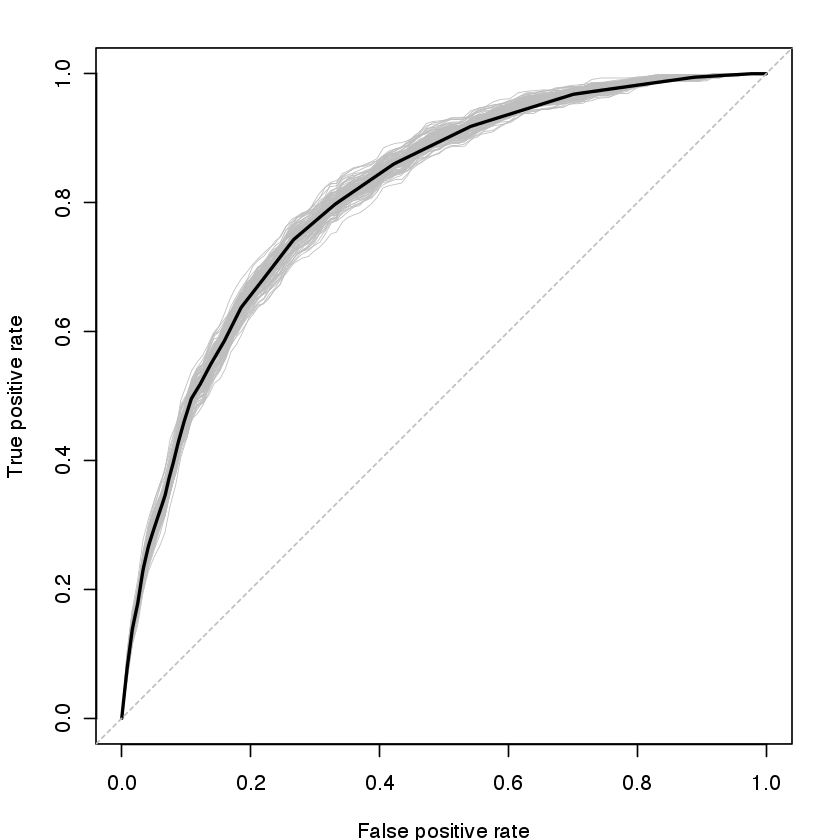

In [4]:
#pdf("data/analysis_3_cvfit-cdtox_all-roc.pdf", width=3.5, height=3.5)
plotROC(perf.cdtox_all, downsampling=100)
#dev.off()

## 1e. Propensity model for either 1a OR 1b OR 1c

In [50]:
cvfit.cdi_union <- cv.glmnet(mat4.no_cdi_equivs, df$cdtox_pcr_positive == 'Y' | df$cdtox_eia_positive == 'Y' | df$cdi_dx == 'Y',
                             family="binomial", alpha=alpha, parallel=TRUE, foldid=foldid, type.measure="auc")

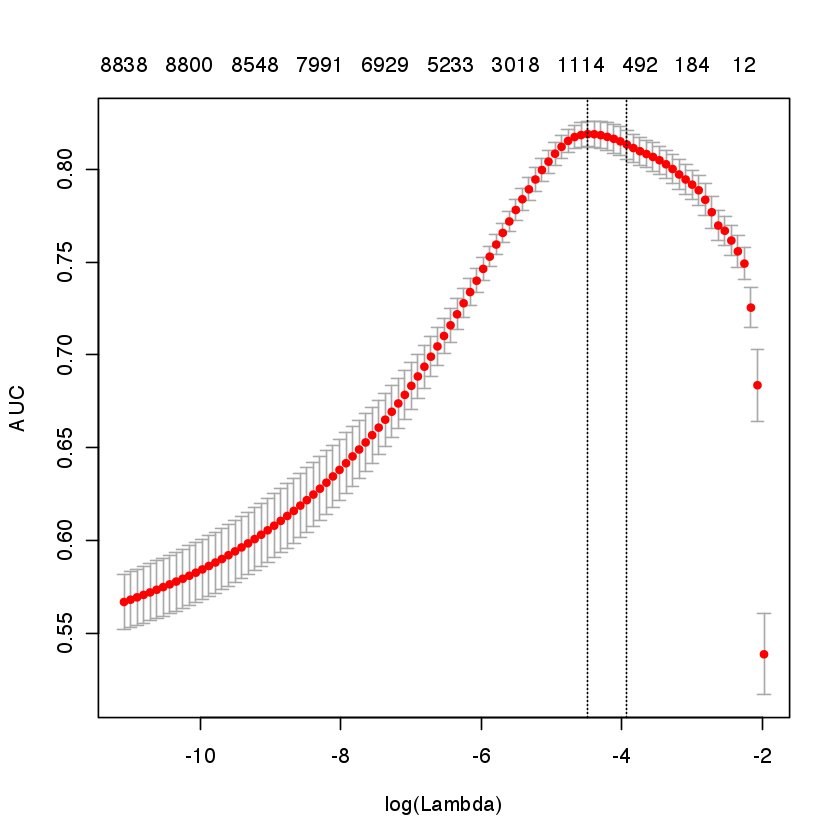

In [102]:
#pdf("data/analysis_3_cvfit-cdi_union.pdf", width=6, height=4.5)
plot(cvfit.cdi_union)
#dev.off()

In [32]:
max(cvfit.cdi_union$cvm)
nrow(summary.glmnet(mat4.no_cdi_equivs, cvfit.cdi_union, "lambda.min"))

[1] 0.8190417

[1] 1028

In [53]:
lapply(list(5, 30), function(nzero) {
    closest_lambda <- cvfit.cdi_union$lambda[[findInterval(nzero, cvfit.cdi_union$nzero[1:50])]]
    summary.glmnet(mat4.no_cdi_equivs, cvfit.cdi_union, closest_lambda)
})

[[1]]
 
     coeff                                  input var
1 -5.05280                                  Intercept
2  0.01993                    meds_administered:17041
3  0.01983                 abnormal_labs:1105-ALBUMIN
4  0.00471           abnormal_labs:1140-PROTEIN TOTAL
5 -0.00455 admission_sources:Non Health Care Facility
6  0.00182                     meds_administered:3474
                           code description
1                                          
2 NYSTATIN 100,000 UNIT/GRAM TOPICAL POWDER
3                                          
4                                          
5                                          
6          NYSTATIN 100,000 UNIT/G OINTMENT

[[2]]
 
      coeff                                  input var
1  -5.06093                                  Intercept
2   2.12887                     meds_administered:4074
3   2.11922                        problem_list:536.49
4   0.14412                    meds_administered:17041
5   0.14345                     meds_administered:3474
6   0.12299                    meds_administered:17145
7   0.10400                   meds_administered:300040
8   0.07213               abnormal_labs:2618-BAND CELL
9   0.05366                 abnormal_labs:1105-ALBUMIN
10  0.05175                     meds_administered:8256
11  0.04913                   meds_administered:400740
12  0.04467           abnormal_labs:2619-METAMYELOCYTE
13  0.03758           abnormal_labs:1140-PROTEIN TOTAL
14  0.02605 admission_sources:Transfer from a Hospital
15 -0.02346 admission_sources:Non Health Care Facility
16  0.02305                     meds_administered:4432
17  0.02187                 abnormal_labs:250-PRO TIME
18  0.01472                   meds_administered:400284
19  0.01237              abnormal_labs:2612-LYMPHOCYTE
20  0.01032                   meds_administered:400183
21  0.00851      abnormal_labs:2608-RED DISTRIB. WIDTH
                                         code description
1                                                        
2                         PROMETHAZINE 6.25 MG/5 ML SYRUP
3                         Other gastrostomy complications
4               NYSTATIN 100,000 UNIT/GRAM TOPICAL POWDER
5                        NYSTATIN 100,000 UNIT/G OINTMENT
6  BACITRACIN-POLYMYXIN B 500 UNIT-10,000 UNIT/G OINTMENT
7                                       GRADE 0 MOUTHWASH
8                                                        
9                                                        
10                                ACYCLOVIR 800 MG TABLET
11                FOSAPREPITANT 150/DEX 12/ZOFRAN 8 COMBO
12                                                       
13                                                       
14                                                       
15                                                       
16                              FLUCONAZOLE 200 MG TABLET
17                                                       
18                         SODIUM CHLORIDE 0.9 % IV BOLUS
19                                                       
20                               MELPHALAN CHEMO INFUSION
21

Qualitatively, this final model seems to be very similar to the `cdtox_pcr_positive=='Y'` model in terms of what coefficients are chosen.

In [54]:
perf.cdi_union <- perf.glmnet(mat4.no_cdi_equivs, df$cdtox_pcr_positive == 'Y' | df$cdtox_eia_positive == 'Y' | df$cdi_dx == 'Y', 
                              cvfit.cdi_union, foldid=foldid, alpha=alpha)

Refitting model to calculate CI, fold 1 of 5
Refitting model to calculate CI, fold 2 of 5
Refitting model to calculate CI, fold 3 of 5
Refitting model to calculate CI, fold 4 of 5
Refitting model to calculate CI, fold 5 of 5


In [55]:
round(mean(as.numeric(perf.cdi_union$auc@y.values)), 2)
round(quantile(as.numeric(perf.cdi_union$auc@y.values), 0.025), 2)
round(quantile(as.numeric(perf.cdi_union$auc@y.values), 0.975), 2)

[1] 0.82

2.5% 
0.81

97.5% 
 0.83

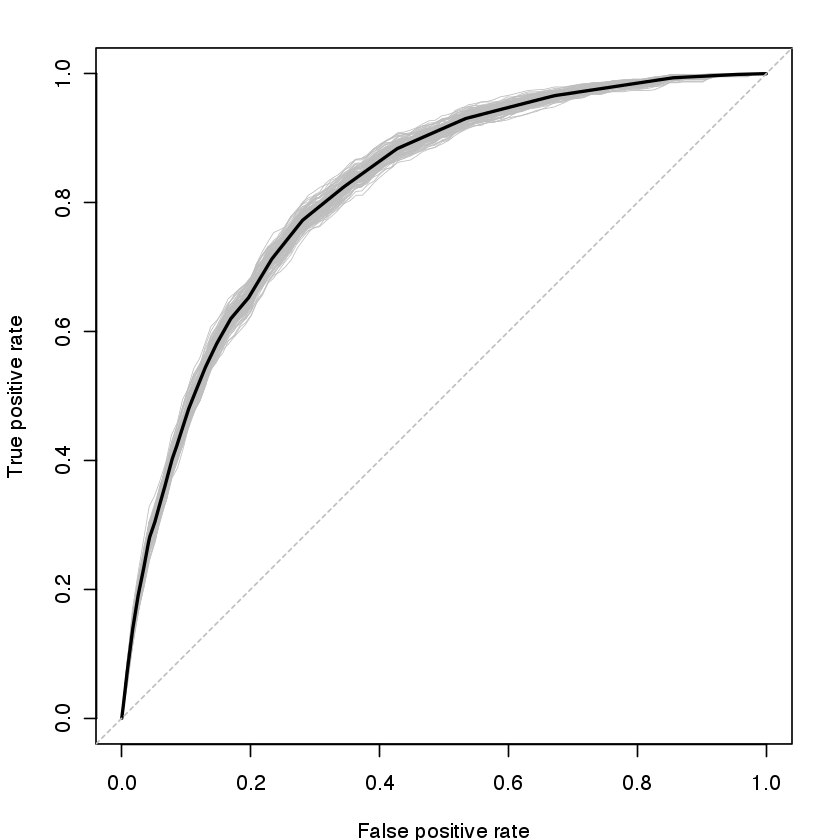

In [105]:
#pdf("data/analysis_3_cvfit-cdi_union-roc.pdf", width=3.5, height=3.5)
plotROC(perf.cdi_union, downsampling=100)
#dev.off()

## Summarize all the variables included in models so far

For the last supplementary table.

In [68]:
sm_all <- lapply(list(cvfit.cdi_dx, cvfit.cdtox_eia, cvfit.cdtox_pcr, cvfit.cdtox_all, cvfit.cdi_union), function(model) {
    summary.glmnet(mat4.no_cdi_equivs, model, "lambda.min")
})
names(sm_all) <- c("cdi_dx", "cdtox_eia", "cdtox_pcr", "cdtox_all", "cdi_union")

sm_all.vars <- unlist(sapply(sm_all, function(sm) {
    sm[,3]
}))
names(sm_all.vars) <- unlist(sapply(sm_all, function(sm) {
    sm[,2]
}))
sm_all.vars <- sm_all.vars[!duplicated(names(sm_all.vars))]

sm_all.df <- data.frame(
    Variable = names(sm_all.vars),
    Description = sm_all.vars,
    # If the following looks insanely verbose, it's because normal subsetting on data frames allows 
    # INEXACT matching on rownames (!!)
    cdi_dx = sm_all[["cdi_dx"]][match(names(sm_all.vars), sm_all[["cdi_dx"]][,2]), 1],
    cdtox_eia = sm_all[["cdtox_eia"]][match(names(sm_all.vars), sm_all[["cdtox_eia"]][,2]), 1],
    cdtox_pcr = sm_all[["cdtox_pcr"]][match(names(sm_all.vars), sm_all[["cdtox_pcr"]][,2]), 1],
    cdtox_all = sm_all[["cdtox_all"]][match(names(sm_all.vars), sm_all[["cdtox_all"]][,2]), 1],
    cdi_union = sm_all[["cdi_union"]][match(names(sm_all.vars), sm_all[["cdi_union"]][,2]), 1]
)
write.table(sm_all.df, file="data/analysis_3_cvfit_models.tsv", sep="\t", row.names=FALSE, quote=FALSE)

Sanity check: are the number of non-`NA` values in the columns equal to the numbers of non-zero coefficients reported previously

In [69]:
sum(!is.na(sm_all.df$cdi_dx))
sum(!is.na(sm_all.df$cdtox_eia))
sum(!is.na(sm_all.df$cdi_union))

[1] 616

[1] 374

[1] 1028

# 2. Analyses that stratify by time of diagnosis

These strata help separate out concerns of reverse causation and/or dependency on the time-to-infection. They also happen to create contrasts between community-acquired and hospital-acquired CDI, going by the traditional NHSN definitions of 72 hours (sometimes 48 hours) as the defined cutoff between these types of infection.

## 2a. Propensity model for (1b OR 1c) AND `cdtox_positive_after < 3`

For this contrast, we have to eliminate (1b OR 1c) AND **NOT** `cdtox_positive_after < 3` from the matrix, because those rows would not be eligible for matching.

In [57]:
cdtox_all_positives <- df$cdtox_pcr_positive == 'Y' | df$cdtox_eia_positive == 'Y'
sum(cdtox_all_positives)
sum(cdtox_all_positives & df$cdtox_positive_after < 3)

eligible.cdtox_all.CA <- !(cdtox_all_positives & !(df$cdtox_positive_after < 3))
sum(eligible.cdtox_all.CA)

[1] 944

[1] 348

[1] 171342

In [58]:
set.seed(82588)
foldid.cdtox_all.CA <- sample(cut(seq(1, sum(eligible.cdtox_all.CA)), breaks=5, labels=FALSE))

cvfit.cdtox_all.CA <- cv.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.CA,], cdtox_all_positives[eligible.cdtox_all.CA],
                                family="binomial", alpha=alpha, parallel=TRUE, foldid=foldid.cdtox_all.CA, type.measure="auc")

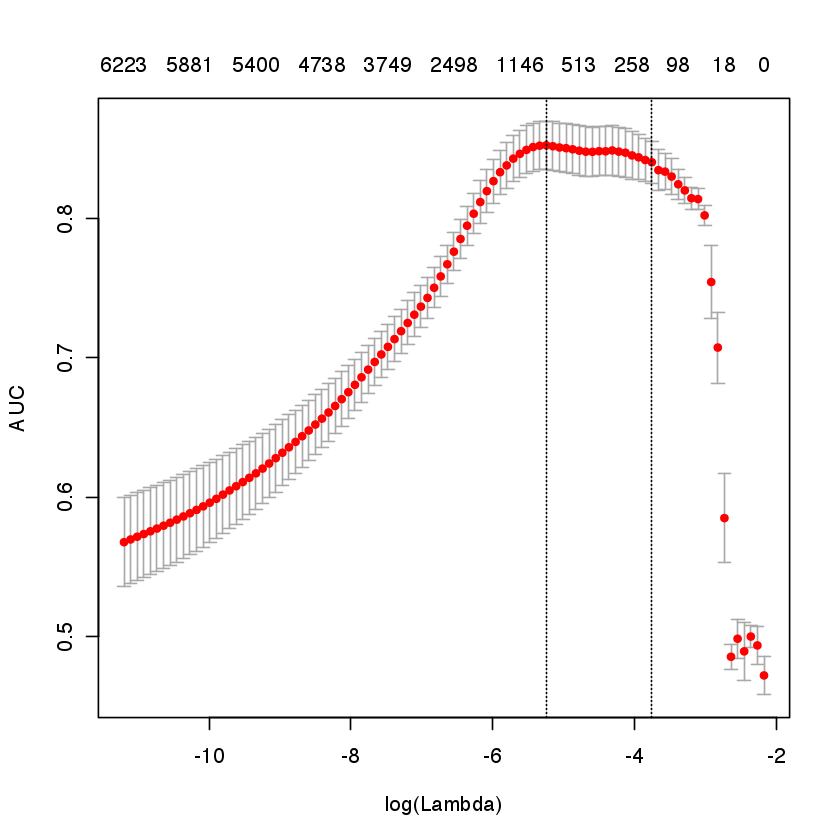

In [107]:
#pdf("data/analysis_3_cvfit-cdtox_all-CA.pdf", width=6, height=4.5)
plot(cvfit.cdtox_all.CA)
#dev.off()

In [60]:
max(cvfit.cdtox_all.CA$cvm)
nrow(summary.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.CA,], cvfit.cdtox_all.CA, "lambda.min"))

[1] 0.853

[1] 766

In [61]:
lapply(list(7, 30), function(nzero) {
    closest_lambda <- cvfit.cdtox_all.CA$lambda[[findInterval(nzero, cvfit.cdtox_all.CA$nzero[1:50])]]
    summary.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.CA,], cvfit.cdtox_all.CA, closest_lambda)
})

[[1]]
 
  coeff              input var                code description
1 -6.20              Intercept                                
2  2.61 meds_administered:4074 PROMETHAZINE 6.25 MG/5 ML SYRUP

[[2]]
 
      coeff                             input var
1  -6.20167                             Intercept
2   4.82696                meds_administered:4074
3   3.50057                    problem_list:477.1
4   3.50057                   meds_reported:31250
5   3.50057                   meds_reported:26285
6   3.50057                    meds_reported:3925
7   3.50057                    meds_reported:1692
8   3.49843               meds_administered:65996
9   3.49843 abnormal_labs:4311-BACT Ag ST.PNEUMO.
10  3.49843                   problem_list:536.49
11  3.49843                   meds_reported:54995
12  3.49843                    meds_reported:9013
13  2.19222                   problem_list:E930.8
14  2.19054                   meds_reported:39806
15  2.17841                   problem_list:569.61
16  2.17667                   meds_reported:14104
17  0.55122                   meds_reported:13705
18  0.44706                     meds_reported:747
19  0.12283                    meds_reported:9542
20  0.09229                    problem_list:556.0
21  0.05332                   meds_reported:37780
22  0.00423              meds_administered:400284
                                                         code description
1                                                                        
2                                         PROMETHAZINE 6.25 MG/5 ML SYRUP
3                                           Allergic rhinitis due to food
4                                            MENTHOL 1.4 % ADHESIVE PATCH
5                              NUT.TX.GLUC.INTOL,LAC-FREE,REG ORAL LIQUID
6                                                       DANAZOL 50 MG CAP
7                                            DIOVAN HCT 80 MG-12.5 MG TAB
8  HEPATITIS B IMMUNE GLOBULIN-MALTOSE >312 UNIT/ML (5 ML) INJECTION SOLN
9                                                                        
10                                        Other gastrostomy complications
11                                          MVI, ADULT NO.1 WITH VIT K IV
12                    FERROUS GLUCONATE 300 MG/5 ML (33.7 MG IRON) ELIXIR
13 Other specified antibiotics causing adverse effects in therapeutic use
14          COD LIVER OIL-VITAMINS A & D-PETROLATUM 96 % TOPICAL OINTMENT
15                                  Infection of colostomy or enterostomy
16                                                UREA 10 % TOPICAL CREAM
17                                      HYDROCORTISONE 100 MG/60 ML ENEMA
18                                          MESALAMINE 4 GRAM/60 ML ENEMA
19                                 MESALAMINE 400 MG TAB, DELAYED RELEASE
20                                     Ulcerative (chronic) enterocolitis
21                                 MESALAMINE 1,000 MG RECTAL SUPPOSITORY
22                                         SODIUM CHLORIDE 0.9 % IV BOLUS

In [62]:
perf.cdtox_all.CA <- perf.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.CA,], cdtox_all_positives[eligible.cdtox_all.CA],
                                 cvfit.cdtox_all.CA, foldid=foldid.cdtox_all.CA, alpha=alpha)

Refitting model to calculate CI, fold 1 of 5
Refitting model to calculate CI, fold 2 of 5
Refitting model to calculate CI, fold 3 of 5
Refitting model to calculate CI, fold 4 of 5
Refitting model to calculate CI, fold 5 of 5


In [63]:
round(mean(as.numeric(perf.cdtox_all.CA$auc@y.values)), 2)
round(quantile(as.numeric(perf.cdtox_all.CA$auc@y.values), 0.025), 2)
round(quantile(as.numeric(perf.cdtox_all.CA$auc@y.values), 0.975), 2)

[1] 0.82

2.5% 
 0.8

97.5% 
 0.84

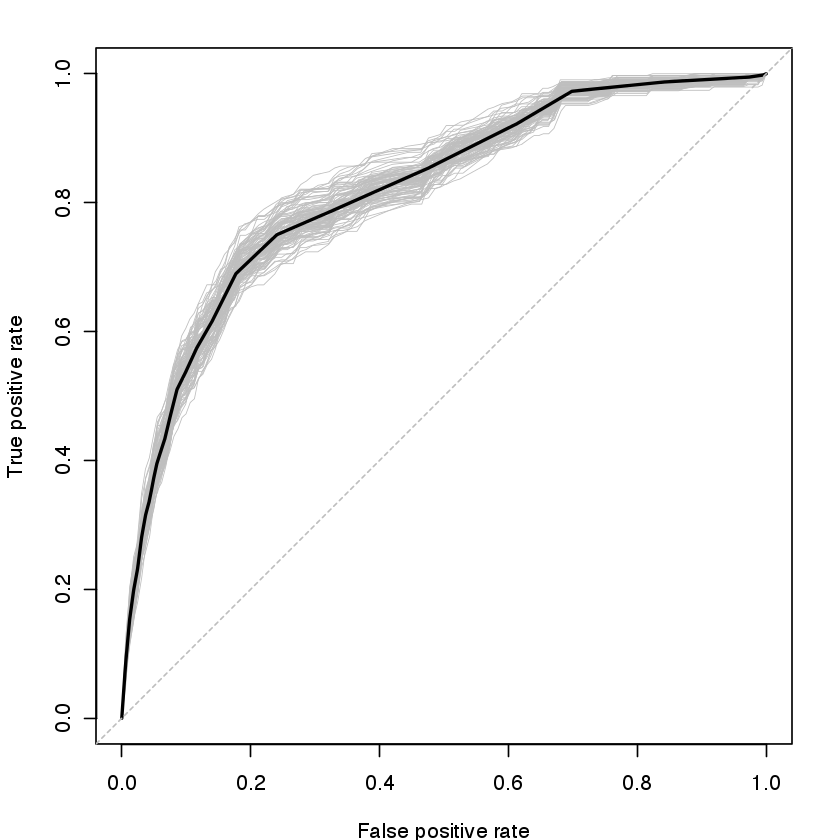

In [109]:
#pdf("data/analysis_3_cvfit-cdtox_all-CA-roc.pdf", width=3.5, height=3.5)
plotROC(perf.cdtox_all.CA, downsampling=100)
#dev.off()

## 2b. Propensity model for (1b OR 1c) AND `cdtox_positive_after >= 3` AND `cdtox_positive_after < 8`

For this contrast, we have to eliminate:

- (1b OR 1c) AND **NOT** (`cdtox_positive_after >= 3` AND `cdtox_positive_after < 8`)

from the matrix, because those rows would not be eligible for matching. Arguably, `length_of_stay < 3` rows could be eliminated as well, since we will exclude visits that are shorter than the lower bound of the time-to-infection window during matching, but the loss of so many training set negatives hurts the performance of the model.

In [65]:
sum(cdtox_all_positives & df$cdtox_positive_after >= 3 & df$cdtox_positive_after < 8)

eligible.cdtox_all.HA_early <- !(
    (cdtox_all_positives & !(df$cdtox_positive_after >= 3 & df$cdtox_positive_after < 8))
)
sum(eligible.cdtox_all.HA_early)

[1] 283

[1] 171277

In [67]:
set.seed(82588)
foldid.cdtox_all.HA_early <- sample(cut(seq(1, sum(eligible.cdtox_all.HA_early)), breaks=5, labels=FALSE))

cvfit.cdtox_all.HA_early <- cv.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.HA_early,], cdtox_all_positives[eligible.cdtox_all.HA_early],
                                      family="binomial", alpha=alpha, parallel=TRUE, foldid=foldid.cdtox_all.HA_early, type.measure="auc")

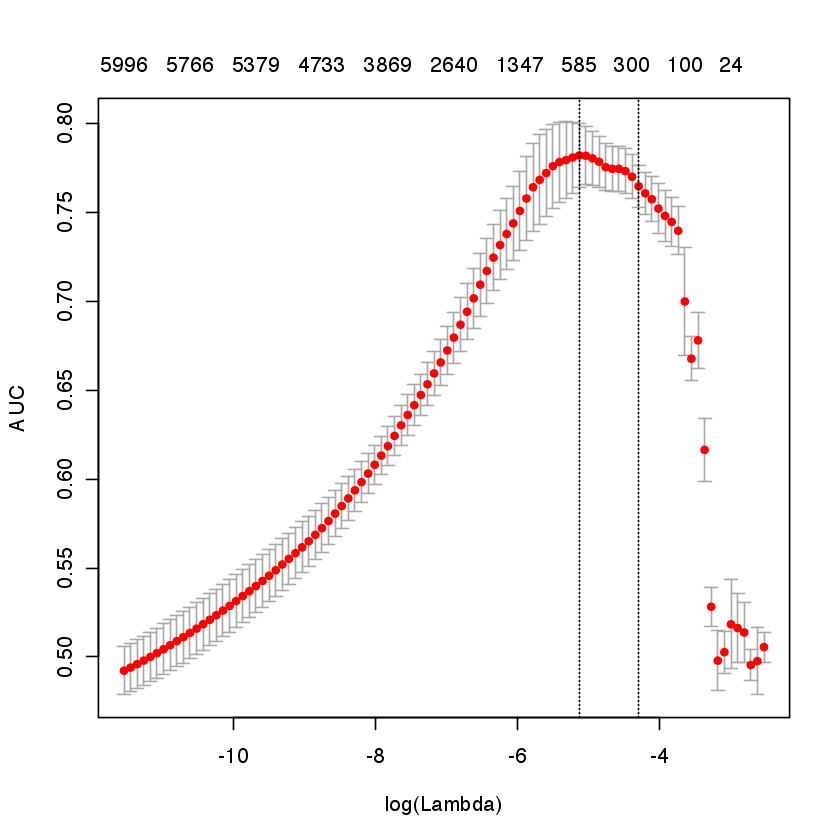

In [68]:
#pdf("data/analysis_3_cvfit-cdtox_all-HA_early.pdf", width=6, height=4.5)
plot(cvfit.cdtox_all.HA_early)
#dev.off()

In [69]:
max(cvfit.cdtox_all.HA_early$cvm)
nrow(summary.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.HA_early,], cvfit.cdtox_all.HA_early, "lambda.min"))

[1] 0.782

[1] 586

In [70]:
lapply(list(7, 30), function(nzero) {
    closest_lambda <- cvfit.cdtox_all.HA_early$lambda[[findInterval(nzero, cvfit.cdtox_all.HA_early$nzero[1:50])]]
    summary.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.HA_early,], cvfit.cdtox_all.HA_early, closest_lambda)
})

[[1]]
 
  coeff input var code description
1  -6.4 Intercept                 

[[2]]
 
      coeff                input var
1  -6.41361                Intercept
2   5.04834      meds_reported:83394
3   5.04834     meds_reported:100591
4   5.04834      meds_reported:10793
5   5.04834      problem_list:512.84
6   5.04834      meds_reported:43905
7   5.04834      problem_list:536.49
8   5.04834      meds_reported:19850
9   5.04834      meds_reported:37860
10  4.74552      meds_reported:46547
11  2.79768      meds_reported:79686
12  2.79767 meds_administered:400916
13  2.78874 meds_administered:400337
14  2.78874      meds_reported:60225
15  1.90713      problem_list:364.41
16  1.90713     meds_reported:101627
17  1.90713     meds_reported:400494
18  1.90713       meds_reported:1997
19  1.86368      meds_reported:15792
20  1.61528      meds_reported:10271
21  1.61278      meds_reported:26129
22  0.97868      problem_list:785.50
23  0.38427      meds_reported:48022
24  0.07674   meds_administered:3474
25  0.07080 meds_administered:400740
26  0.04025      problem_list:403.00
27  0.04025      meds_reported:37763
28  0.04025      meds_reported:96686
29  0.01376 meds_administered:300040
30  0.00974  meds_administered:17145
                                                                                                       code description
1                                                                                                                      
2                                                                                                RENO CAPS 1 MG CAPSULE
3                                                                                                   LUTEIN 20 MG TABLET
4                                                                               LODOXAMIDE TROMETHAMINE 0.1 % EYE DROPS
5                                                                                                        Other air leak
6                                                                                                            BUMEX ORAL
7                                                                                       Other gastrostomy complications
8                                                                                             CIPROFLOXACIN 10 MG/ML IV
9                                                                                        HALOPERIDOL 5 MG/ML IM SYRINGE
10                                                                                    DAILY MULTIPLE VITAMINS/IRON ORAL
11                                                                                       PROTEIN SUPPLEMENT ORAL LIQUID
12                                                                 POTASSIUM CHLORIDE IV SYRINGE 0.1 MEQ/ML STERILE DIL
13                                                                                                  GANCICLOVIR SYRINGE
14                                                                                                         SENNA-S ORAL
15                                                                                     Hyphema of iris and ciliary body
16                                                                                               METOCLOPRAMIDE HCL INJ
17                                                                  FUROSEMIDE IV BURITROL SYRINGE 10 MG/ML STERILE DIL
18                                                                                                 INDINAVIR 400 MG CAP
19                                                                                    PRAMOXINE-CALAMINE 1 %-8 % LOTION
20                                                                                           CYCLOPHOSPHAMIDE 25 MG TAB
21                                                                                                 CELECOXIB 400 MG CAP
22                                                                                                   Shock, unspecified
23    

In [71]:
perf.cdtox_all.HA_early <- perf.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.HA_early,], cdtox_all_positives[eligible.cdtox_all.HA_early],
                                       cvfit.cdtox_all.HA_early, foldid=foldid.cdtox_all.HA_early, alpha=alpha)

Refitting model to calculate CI, fold 1 of 5
Refitting model to calculate CI, fold 2 of 5
Refitting model to calculate CI, fold 3 of 5
Refitting model to calculate CI, fold 4 of 5
Refitting model to calculate CI, fold 5 of 5


In [72]:
round(mean(as.numeric(perf.cdtox_all.HA_early$auc@y.values)), 2)
round(quantile(as.numeric(perf.cdtox_all.HA_early$auc@y.values), 0.025), 2)
round(quantile(as.numeric(perf.cdtox_all.HA_early$auc@y.values), 0.975), 2)

[1] 0.75

2.5% 
0.71

97.5% 
 0.77

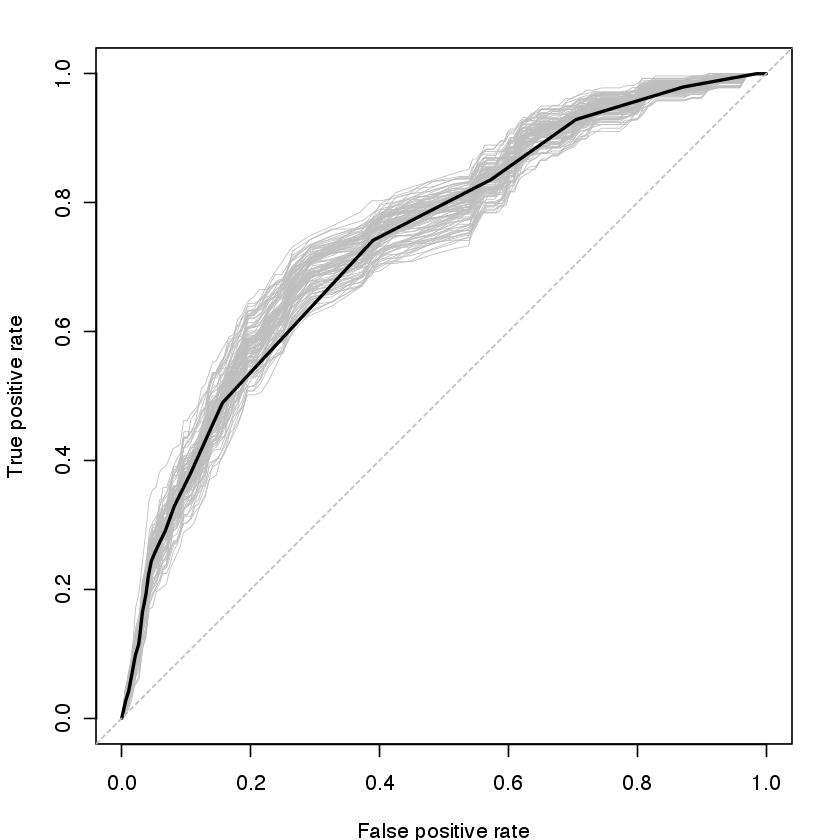

In [111]:
#pdf("data/analysis_3_cvfit-cdtox_all-HA_early-roc.pdf", width=3.5, height=3.5)
plotROC(perf.cdtox_all.HA_early, downsampling=100)
#dev.off()

## 2c. Propensity model for (1b OR 1c) AND `cdtox_positive_after >= 8`

For this contrast, we have to eliminate:

- (1b OR 1c) AND **NOT** `cdtox_positive_after >= 8`

from the matrix, because those rows would not be eligible for matching. Arguably, `length_of_stay < 8` rows could be eliminated as well, since we will exclude visits that are shorter than the lower bound of the time-to-infection window during matching, but the loss of so many training set negatives hurts the performance of the model.

In [74]:
sum(cdtox_all_positives & df$cdtox_positive_after >= 8)

eligible.cdtox_all.HA_late <- !(
    (cdtox_all_positives & !(df$cdtox_positive_after >= 8))
    #| df$length_of_stay < 8
)
sum(eligible.cdtox_all.HA_late)

[1] 313

[1] 171307

In [75]:
set.seed(82588)
foldid.cdtox_all.HA_late <- sample(cut(seq(1, sum(eligible.cdtox_all.HA_late)), breaks=5, labels=FALSE))

cvfit.cdtox_all.HA_late <- cv.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.HA_late,], cdtox_all_positives[eligible.cdtox_all.HA_late],
                                      family="binomial", alpha=alpha, parallel=TRUE, foldid=foldid.cdtox_all.HA_late, type.measure="auc")

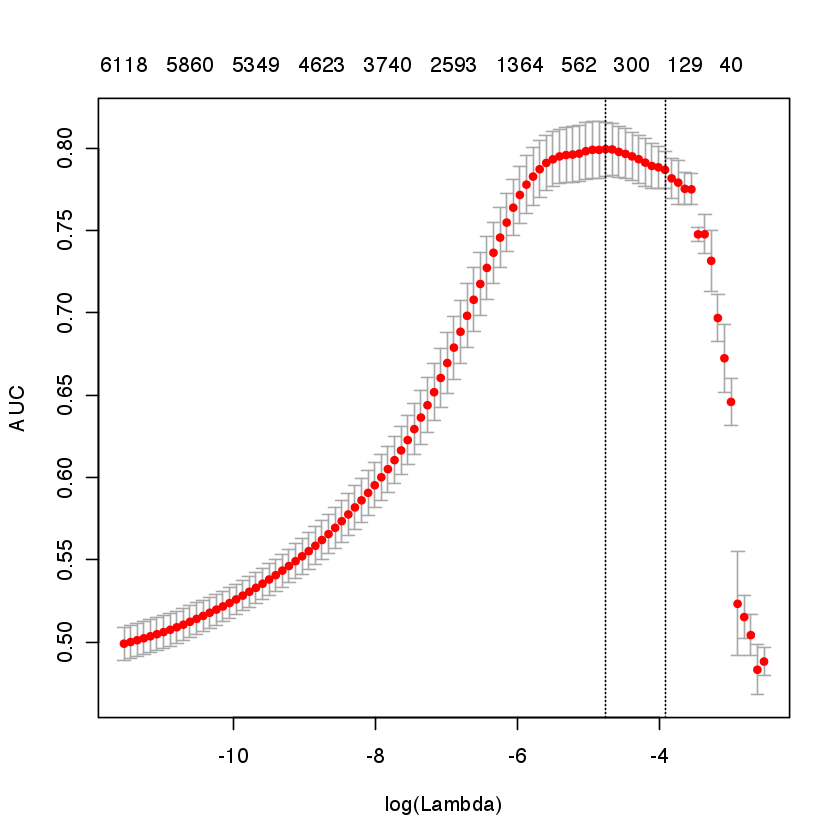

In [113]:
#pdf("data/analysis_3_cvfit-cdtox_all-HA_late.pdf", width=6, height=4.5)
plot(cvfit.cdtox_all.HA_late)
#dev.off()

In [77]:
max(cvfit.cdtox_all.HA_late$cvm)
nrow(summary.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.HA_late,], cvfit.cdtox_all.HA_late, "lambda.min"))

[1] 0.799

[1] 424

In [78]:
lapply(list(7, 30), function(nzero) {
    closest_lambda <- cvfit.cdtox_all.HA_late$lambda[[findInterval(nzero, cvfit.cdtox_all.HA_late$nzero[1:50])]]
    summary.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.HA_late,], cvfit.cdtox_all.HA_late, closest_lambda)
})

[[1]]
 
  coeff input var code description
1  -6.3 Intercept                 

[[2]]
 
   coeff            input var
1  -6.31            Intercept
2   3.33 meds_reported:600609
3   3.33   problem_list:269.1
4   3.33 meds_reported:400919
5   3.33  problem_list:209.26
6   3.33   problem_list:077.1
7   3.33 meds_reported:400699
8   3.33  meds_reported:96857
9   3.33   meds_reported:2536
10  3.33  meds_reported:18521
11  3.33  meds_reported:79819
12  3.33 meds_reported:400941
13  3.33  meds_reported:95567
14  2.15  meds_reported:45575
15  2.15  meds_reported:37202
16  2.14  meds_reported:84060
17  2.14  meds_reported:52859
18  1.21 meds_reported:400155
19  1.20  meds_reported:58663
20  1.17  meds_reported:44709
21  1.17    meds_reported:519
                                                      code description
1                                                                     
2                                                                  GCO
3                                         Deficiency of other vitamins
4                   ACETAMINOPHEN 650 MG IN STERILE DILUENT 65 ML IVPB
5         Malignant carcinoid tumor of midgut, not otherwise specified
6                                        Epidemic keratoconjunctivitis
7                                      TIGECYCLINE 50 MG/50 ML NS IVPB
8                      CEFTAROLINE FOSAMIL 600 MG INTRAVENOUS SOLUTION
9                                ACETAMINOPHEN 160 MG/5 ML ORAL LIQUID
10                AMPHOTERICIN B LIPOSOME 50 MG INTRAVENOUS SUSPENSION
11                                            BRIMONIDINE-TIMOLOL OPHT
12                                        CEFAZOLIN IN 150 ML D5W IVPB
13         GLUCAGON (HUMAN RECOMBINANT) 1 MG/ML SOLUTION FOR INJECTION
14                                                    CLOXACILLIN ORAL
15 MORPHINE 1 MG/ML IN 0.9 % SODIUM CHLORIDE INJECTABLE PUMP RESERVOIR
16                                                ESTROVEN ENERGY ORAL
17                                                         LEVOPHED IV
18                                                    GANCICLOVIR IVPB
19                                                          PROGRAF IV
20                                             CELLCEPT INTRAVENOUS IV
21                                      GANCICLOVIR 500 MG IV SOLUTION

In [79]:
perf.cdtox_all.HA_late <- perf.glmnet(mat4.no_cdi_equivs[eligible.cdtox_all.HA_late,], cdtox_all_positives[eligible.cdtox_all.HA_late],
                                       cvfit.cdtox_all.HA_late, foldid=foldid.cdtox_all.HA_late, alpha=alpha)

Refitting model to calculate CI, fold 1 of 5
Refitting model to calculate CI, fold 2 of 5
Refitting model to calculate CI, fold 3 of 5
Refitting model to calculate CI, fold 4 of 5
Refitting model to calculate CI, fold 5 of 5


In [80]:
round(mean(as.numeric(perf.cdtox_all.HA_late$auc@y.values)), 2)
round(quantile(as.numeric(perf.cdtox_all.HA_late$auc@y.values), 0.025), 2)
round(quantile(as.numeric(perf.cdtox_all.HA_late$auc@y.values), 0.975), 2)

[1] 0.78

2.5% 
0.74

97.5% 
  0.8

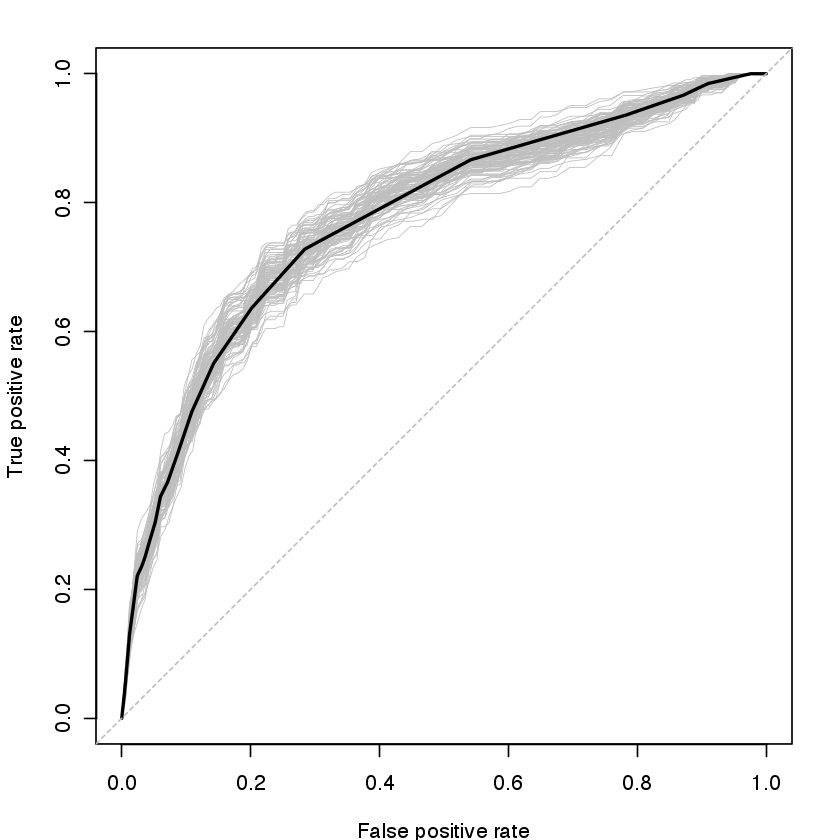

In [115]:
#pdf("data/analysis_3_cvfit-cdtox_all-HA_late-roc.pdf", width=3.5, height=3.5)
plotROC(perf.cdtox_all.HA_late, downsampling=100)
#dev.off()

# Saving all of this

In [82]:
ls()

[1] "alpha"                           "alphas"                         
 [3] "cdtox_all_positives"             "confusionMatrix"                
 [5] "cvfit.cdi_dx"                    "cvfit.cdi_dx.lambda_min.summary"
 [7] "cvfit.cdi_union"                 "cvfit.cdtox_all"                
 [9] "cvfit.cdtox_all.CA"              "cvfit.cdtox_all.HA_early"       
[11] "cvfit.cdtox_all.HA_late"         "cvfit.cdtox_eia"                
[13] "cvfit.cdtox_pcr"                 "cvfit.warmup"                   
[15] "cvfits.cdi_dx"                   "de_code"                        
[17] "df"                              "dx.df"                          
[19] "eligible.cdtox_all.CA"           "eligible.cdtox_all.HA_early"    
[21] "eligible.cdtox_all.HA_late"      "excluded_cols"                  
[23] "excluded_meds"                   "fit.warmup"                     
[25] "foldid"                          "foldid.cdtox_all.CA"            
[27] "foldid.cdtox_all.HA_early"       "foldid.cdtox_all.HA_late"       
[29] "foldid.cdtox_eia"                "foldid.cdtox_pcr"               
[31] "icd9_to_name"                    "mat4"                           
[33] "mat4.no_cdi_equivs"              "med_code_to_name"               
[35] "med.df"                          "perf.cdi_dx"                    
[37] "perf.cdi_union"                  "perf.cdtox_all"                 
[39] "perf.cdtox_all.CA"               "perf.cdtox_all.HA_early"        
[41] "perf.cdtox_all.HA_late"          "perf.cdtox_eia"                 
[43] "perf.cdtox_pcr"                  "perf.glmnet"                    
[45] "plot.cvfits.alphas"              "plotROC"                        
[47] "summary.glmnet"

In [83]:
save(alpha, alphas, cvfit.cdi_dx, cvfit.cdtox_eia, cvfit.cdtox_pcr, cvfit.cdtox_all, cvfit.cdi_union, 
     cvfit.cdtox_all.CA, cvfit.cdtox_all.HA_early, cvfit.cdtox_all.HA_late,
     eligible.cdtox_all.CA, eligible.cdtox_all.HA_early, eligible.cdtox_all.HA_late,
     cvfits.cdi_dx,
     mat4, mat4.no_cdi_equivs,
     foldid, foldid.cdtox_eia, foldid.cdtox_pcr, foldid.cdtox_all.CA, foldid.cdtox_all.HA_early, foldid.cdtox_all.HA_late,
     file="data/analysis_3_glmnet.RData")

The performance data is somewhat large (~3GB) and unnecessary for the following steps, so we save it separately

In [84]:
save(perf.cdi_dx, perf.cdtox_eia, perf.cdtox_pcr, perf.cdtox_all, perf.cdi_union,
     perf.cdtox_all.CA, perf.cdtox_all.HA_early, perf.cdtox_all.HA_late,
     file="data/analysis_3_glmnet_perf.RData")